# Inference and Validation

Now that you have a trained network, you can use it for making predictions. This is typically called **inference**, a term borrowed from statistics. However, neural networks have a tendency to perform *too well* on the training data and aren't able to generalize to data that hasn't been seen before. This is called **overfitting** and it impairs inference performance. To test for overfitting while training, we measure the performance on data not in the training set called the **validation** set. We avoid overfitting through regularization such as dropout while monitoring the validation performance during training. In this notebook, I'll show you how to do this in PyTorch. 

As usual, let's start by loading the dataset through torchvision. You'll learn more about torchvision and loading data in a later part. This time we'll be taking advantage of the test set which you can get by setting `train=False` here:

```python
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
```

The test set contains images just like the training set. Typically you'll see 10-20% of the original dataset held out for testing and validation with the rest being used for training.

In [8]:
import torch
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

Here I'll create a model like normal, using the same one from my solution for part 4.

In [9]:
from torch import nn, optim
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

The goal of validation is to measure the model's performance on data that isn't part of the training set. Performance here is up to the developer to define though. Typically this is just accuracy, the percentage of classes the network predicted correctly. Other options are [precision and recall](https://en.wikipedia.org/wiki/Precision_and_recall#Definition_(classification_context)) and top-5 error rate. We'll focus on accuracy here. First I'll do a forward pass with one batch from the test set.

In [10]:
model = Classifier()

images, labels = next(iter(testloader))
# Get the class probabilities
ps = torch.exp(model(images))
# Make sure the shape is appropriate, we should get 10 class probabilities for 64 examples
print(ps.shape)

torch.Size([64, 10])


With the probabilities, we can get the most likely class using the `ps.topk` method. This returns the $k$ highest values. Since we just want the most likely class, we can use `ps.topk(1)`. This returns a tuple of the top-$k$ values and the top-$k$ indices. If the highest value is the fifth element, we'll get back 4 as the index.

In [11]:
top_p, top_class = ps.topk(1, dim=1)
# Look at the most likely classes for the first 10 examples
print(top_class[:10,:])

tensor([[7],
        [7],
        [7],
        [7],
        [7],
        [7],
        [7],
        [7],
        [7],
        [7]])


Now we can check if the predicted classes match the labels. This is simple to do by equating `top_class` and `labels`, but we have to be careful of the shapes. Here `top_class` is a 2D tensor with shape `(64, 1)` while `labels` is 1D with shape `(64)`. To get the equality to work out the way we want, `top_class` and `labels` must have the same shape.

If we do

```python
equals = top_class == labels
```

`equals` will have shape `(64, 64)`, try it yourself. What it's doing is comparing the one element in each row of `top_class` with each element in `labels` which returns 64 True/False boolean values for each row.

In [12]:
equals = top_class == labels.view(*top_class.shape)

Now we need to calculate the percentage of correct predictions. `equals` has binary values, either 0 or 1. This means that if we just sum up all the values and divide by the number of values, we get the percentage of correct predictions. This is the same operation as taking the mean, so we can get the accuracy with a call to `torch.mean`. If only it was that simple. If you try `torch.mean(equals)`, you'll get an error

```
RuntimeError: mean is not implemented for type torch.ByteTensor
```

This happens because `equals` has type `torch.ByteTensor` but `torch.mean` isn't implemented for tensors with that type. So we'll need to convert `equals` to a float tensor. Note that when we take `torch.mean` it returns a scalar tensor, to get the actual value as a float we'll need to do `accuracy.item()`.

In [13]:
accuracy = torch.mean(equals.type(torch.FloatTensor))
print(f'Accuracy: {accuracy.item()*100}%')

Accuracy: 12.5%


The network is untrained so it's making random guesses and we should see an accuracy around 10%. Now let's train our network and include our validation pass so we can measure how well the network is performing on the test set. Since we're not updating our parameters in the validation pass, we can speed up our code by turning off gradients using `torch.no_grad()`:

```python
# turn off gradients
with torch.no_grad():
    # validation pass here
    for images, labels in testloader:
        ...
```

>**Exercise:** Implement the validation loop below and print out the total accuracy after the loop. You can largely copy and paste the code from above, but I suggest typing it in because writing it out yourself is essential for building the skill. In general you'll always learn more by typing it rather than copy-pasting. You should be able to get an accuracy above 80%.

In [18]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 30
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        ## TODO: Implement the validation pass and print out the validation accuracy
        with torch.no_grad():
            test_loss = 0
            accuracy = 0
            for images, labels in testloader:
                # Get the class probabilities
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(model(images))
                top_p, top_class = ps.topk(1, dim=1)
                # Look at the most likely classes for the first 10 examples
                print(top_class[:10,:])
                equals = top_class == labels.view(*top_class.shape)
                accuracy = torch.mean(equals.type(torch.FloatTensor))
                
        print(f'Accuracy: {accuracy.item()*100}%')

tensor([[3],
        [8],
        [3],
        [2],
        [2],
        [7],
        [7],
        [1],
        [0],
        [3]])
Accuracy: 84.375%
tensor([[3],
        [7],
        [7],
        [3],
        [4],
        [1],
        [1],
        [2],
        [7],
        [7]])
Accuracy: 79.6875%
tensor([[9],
        [3],
        [7],
        [9],
        [6],
        [9],
        [1],
        [6],
        [5],
        [8]])
Accuracy: 85.9375%
tensor([[2],
        [2],
        [9],
        [3],
        [3],
        [3],
        [8],
        [1],
        [0],
        [2]])
Accuracy: 85.9375%
tensor([[0],
        [6],
        [3],
        [6],
        [6],
        [3],
        [3],
        [3],
        [8],
        [3]])
Accuracy: 85.9375%
tensor([[0],
        [2],
        [0],
        [1],
        [8],
        [2],
        [5],
        [8],
        [3],
        [5]])
Accuracy: 85.9375%
tensor([[7],
        [4],
        [0],
        [0],
        [8],
        [9],
        [4],
        [7

Accuracy: 85.9375%
tensor([[1],
        [0],
        [0],
        [1],
        [1],
        [1],
        [4],
        [1],
        [2],
        [2]])
Accuracy: 85.9375%
tensor([[4],
        [0],
        [5],
        [3],
        [7],
        [9],
        [2],
        [7],
        [9],
        [7]])
Accuracy: 76.5625%
tensor([[7],
        [2],
        [0],
        [3],
        [8],
        [4],
        [9],
        [2],
        [4],
        [4]])
Accuracy: 90.625%
tensor([[9],
        [8],
        [3],
        [4],
        [2],
        [5],
        [2],
        [1],
        [2],
        [9]])
Accuracy: 92.1875%
tensor([[1],
        [2],
        [1],
        [6],
        [2],
        [7],
        [6],
        [6],
        [8],
        [3]])
Accuracy: 84.375%
tensor([[7],
        [0],
        [5],
        [8],
        [7],
        [1],
        [0],
        [6],
        [6],
        [6]])
Accuracy: 81.25%
tensor([[0],
        [2],
        [2],
        [2],
        [7],
        [6],
       

        [0]])
Accuracy: 84.375%
tensor([[8],
        [7],
        [1],
        [1],
        [8],
        [2],
        [1],
        [4],
        [3],
        [3]])
Accuracy: 82.8125%
tensor([[3],
        [3],
        [2],
        [8],
        [5],
        [7],
        [9],
        [8],
        [5],
        [8]])
Accuracy: 85.9375%
tensor([[7],
        [9],
        [9],
        [3],
        [5],
        [2],
        [2],
        [3],
        [4],
        [3]])
Accuracy: 89.0625%
tensor([[2],
        [9],
        [3],
        [6],
        [2],
        [3],
        [5],
        [1],
        [2],
        [6]])
Accuracy: 82.8125%
tensor([[5],
        [5],
        [9],
        [2],
        [3],
        [0],
        [2],
        [8],
        [9],
        [9]])
Accuracy: 87.5%
tensor([[0],
        [2],
        [2],
        [1],
        [2],
        [9],
        [0],
        [9],
        [6],
        [7]])
Accuracy: 82.8125%
tensor([[9],
        [1],
        [8],
        [9],
        [1],
      

        [8]])
Accuracy: 79.6875%
tensor([[3],
        [8],
        [9],
        [3],
        [1],
        [6],
        [2],
        [7],
        [3],
        [1]])
Accuracy: 92.1875%
tensor([[9],
        [3],
        [6],
        [9],
        [0],
        [8],
        [5],
        [0],
        [8],
        [1]])
Accuracy: 85.9375%
tensor([[9],
        [8],
        [2],
        [4],
        [2],
        [4],
        [9],
        [9],
        [4],
        [8]])
Accuracy: 76.5625%
tensor([[7],
        [9],
        [7],
        [3],
        [0],
        [6],
        [7],
        [1],
        [4],
        [8]])
Accuracy: 84.375%
tensor([[7],
        [2],
        [2],
        [0],
        [5],
        [6],
        [7],
        [4],
        [7],
        [3]])
Accuracy: 89.0625%
tensor([[3],
        [5],
        [1],
        [8],
        [2],
        [4],
        [9],
        [8],
        [8],
        [9]])
Accuracy: 84.375%
tensor([[8],
        [7],
        [7],
        [4],
        [0],
    

        [8]])
Accuracy: 82.8125%
tensor([[2],
        [3],
        [8],
        [9],
        [2],
        [8],
        [1],
        [7],
        [0],
        [8]])
Accuracy: 84.375%
tensor([[0],
        [1],
        [0],
        [5],
        [9],
        [0],
        [3],
        [9],
        [3],
        [9]])
Accuracy: 90.625%
tensor([[0],
        [2],
        [3],
        [4],
        [6],
        [1],
        [4],
        [1],
        [9],
        [7]])
Accuracy: 89.0625%
tensor([[8],
        [3],
        [9],
        [9],
        [8],
        [5],
        [5],
        [2],
        [5],
        [3]])
Accuracy: 85.9375%
tensor([[0],
        [9],
        [3],
        [4],
        [6],
        [3],
        [6],
        [3],
        [5],
        [5]])
Accuracy: 89.0625%
tensor([[0],
        [3],
        [7],
        [2],
        [3],
        [8],
        [2],
        [5],
        [1],
        [3]])
Accuracy: 79.6875%
tensor([[9],
        [2],
        [5],
        [5],
        [8],
    

        [5]])
Accuracy: 89.0625%
tensor([[0],
        [0],
        [9],
        [9],
        [1],
        [5],
        [5],
        [0],
        [3],
        [2]])
Accuracy: 76.5625%
tensor([[0],
        [0],
        [7],
        [3],
        [6],
        [9],
        [6],
        [4],
        [1],
        [0]])
Accuracy: 87.5%
tensor([[2],
        [8],
        [7],
        [9],
        [6],
        [3],
        [2],
        [8],
        [8],
        [3]])
Accuracy: 81.25%
tensor([[7],
        [1],
        [1],
        [9],
        [5],
        [5],
        [6],
        [9],
        [7],
        [6]])
Accuracy: 87.5%
tensor([[6],
        [6],
        [8],
        [3],
        [8],
        [9],
        [7],
        [6],
        [0],
        [9]])
Accuracy: 89.0625%
tensor([[2],
        [6],
        [4],
        [1],
        [3],
        [9],
        [6],
        [9],
        [4],
        [4]])
Accuracy: 85.9375%
tensor([[0],
        [0],
        [9],
        [9],
        [3],
        [9

        [3]])
Accuracy: 82.8125%
tensor([[9],
        [0],
        [0],
        [8],
        [5],
        [3],
        [3],
        [2],
        [4],
        [4]])
Accuracy: 81.25%
tensor([[1],
        [1],
        [3],
        [9],
        [7],
        [3],
        [2],
        [3],
        [0],
        [4]])
Accuracy: 84.375%
tensor([[0],
        [0],
        [8],
        [5],
        [0],
        [0],
        [2],
        [0],
        [3],
        [9]])
Accuracy: 78.125%
tensor([[9],
        [0],
        [3],
        [8],
        [9],
        [6],
        [5],
        [3],
        [4],
        [9]])
Accuracy: 85.9375%
tensor([[5],
        [1],
        [0],
        [4],
        [7],
        [8],
        [1],
        [3],
        [6],
        [6]])
Accuracy: 85.9375%
tensor([[2],
        [7],
        [2],
        [4],
        [2],
        [4],
        [3],
        [3],
        [4],
        [1]])
Accuracy: 89.0625%
tensor([[3],
        [6],
        [8],
        [9],
        [7],
      

        [9]])
Accuracy: 81.25%
tensor([[7],
        [7],
        [7],
        [2],
        [2],
        [8],
        [1],
        [3],
        [1],
        [9]])
Accuracy: 89.0625%
tensor([[0],
        [1],
        [2],
        [7],
        [4],
        [4],
        [8],
        [8],
        [9],
        [5]])
Accuracy: 85.9375%
tensor([[1],
        [2],
        [3],
        [6],
        [6],
        [1],
        [9],
        [8],
        [5],
        [2]])
Accuracy: 95.3125%
tensor([[3],
        [0],
        [2],
        [4],
        [2],
        [4],
        [0],
        [6],
        [4],
        [3]])
Accuracy: 84.375%
tensor([[1],
        [8],
        [6],
        [6],
        [2],
        [4],
        [4],
        [2],
        [1],
        [7]])
Accuracy: 85.9375%
tensor([[9],
        [4],
        [1],
        [8],
        [3],
        [2],
        [3],
        [5],
        [7],
        [0]])
Accuracy: 90.625%
tensor([[9],
        [1],
        [8],
        [6],
        [9],
      

        [5]])
Accuracy: 90.625%
tensor([[3],
        [5],
        [7],
        [4],
        [9],
        [9],
        [4],
        [8],
        [7],
        [5]])
Accuracy: 85.9375%
tensor([[4],
        [0],
        [6],
        [6],
        [7],
        [9],
        [5],
        [8],
        [4],
        [9]])
Accuracy: 85.9375%
tensor([[8],
        [6],
        [5],
        [2],
        [4],
        [1],
        [1],
        [9],
        [1],
        [2]])
Accuracy: 87.5%
tensor([[1],
        [0],
        [0],
        [3],
        [8],
        [0],
        [0],
        [2],
        [0],
        [3]])
Accuracy: 87.5%
tensor([[6],
        [6],
        [7],
        [1],
        [0],
        [2],
        [6],
        [4],
        [5],
        [0]])
Accuracy: 82.8125%
tensor([[3],
        [8],
        [8],
        [0],
        [7],
        [0],
        [0],
        [8],
        [1],
        [5]])
Accuracy: 82.8125%
tensor([[0],
        [3],
        [9],
        [0],
        [8],
        [

        [6]])
Accuracy: 87.5%
tensor([[9],
        [1],
        [7],
        [5],
        [8],
        [5],
        [2],
        [3],
        [0],
        [9]])
Accuracy: 93.75%
tensor([[2],
        [9],
        [6],
        [9],
        [4],
        [4],
        [8],
        [7],
        [7],
        [4]])
Accuracy: 84.375%
tensor([[9],
        [5],
        [5],
        [4],
        [8],
        [9],
        [1],
        [6],
        [5],
        [3]])
Accuracy: 85.9375%
tensor([[4],
        [5],
        [7],
        [1],
        [8],
        [2],
        [2],
        [0],
        [8],
        [2]])
Accuracy: 92.1875%
tensor([[0],
        [5],
        [4],
        [5],
        [9],
        [7],
        [3],
        [5],
        [4],
        [5]])
Accuracy: 90.625%
tensor([[4],
        [8],
        [8],
        [4],
        [0],
        [6],
        [4],
        [5],
        [9],
        [9]])
Accuracy: 79.6875%
tensor([[0],
        [2],
        [8],
        [1],
        [8],
        [

        [4]])
Accuracy: 81.25%
tensor([[6],
        [3],
        [9],
        [6],
        [8],
        [9],
        [3],
        [4],
        [9],
        [4]])
Accuracy: 85.9375%
tensor([[1],
        [1],
        [3],
        [2],
        [8],
        [8],
        [2],
        [8],
        [8],
        [4]])
Accuracy: 81.25%
tensor([[8],
        [8],
        [7],
        [0],
        [8],
        [9],
        [4],
        [5],
        [9],
        [5]])
Accuracy: 89.0625%
tensor([[2],
        [2],
        [9],
        [8],
        [7],
        [6],
        [4],
        [0],
        [7],
        [4]])
Accuracy: 78.125%
tensor([[8],
        [5],
        [9],
        [6],
        [0],
        [9],
        [5],
        [7],
        [8],
        [7]])
Accuracy: 89.0625%
tensor([[4],
        [0],
        [8],
        [7],
        [6],
        [3],
        [0],
        [0],
        [7],
        [1]])
Accuracy: 84.375%
tensor([[3],
        [4],
        [7],
        [1],
        [2],
        

        [3]])
Accuracy: 79.6875%
tensor([[3],
        [9],
        [8],
        [4],
        [0],
        [3],
        [9],
        [3],
        [0],
        [9]])
Accuracy: 85.9375%
tensor([[8],
        [8],
        [4],
        [3],
        [6],
        [0],
        [9],
        [9],
        [5],
        [5]])
Accuracy: 82.8125%
tensor([[5],
        [6],
        [6],
        [0],
        [3],
        [3],
        [0],
        [1],
        [5],
        [6]])
Accuracy: 84.375%
tensor([[9],
        [4],
        [6],
        [8],
        [3],
        [6],
        [0],
        [0],
        [7],
        [7]])
Accuracy: 90.625%
tensor([[7],
        [6],
        [4],
        [7],
        [2],
        [1],
        [7],
        [1],
        [3],
        [3]])
Accuracy: 84.375%
tensor([[5],
        [3],
        [8],
        [1],
        [2],
        [7],
        [6],
        [2],
        [6],
        [4]])
Accuracy: 90.625%
tensor([[9],
        [0],
        [6],
        [1],
        [5],
      

        [3]])
Accuracy: 90.625%
tensor([[4],
        [4],
        [3],
        [7],
        [1],
        [2],
        [2],
        [5],
        [3],
        [6]])
Accuracy: 81.25%
tensor([[6],
        [3],
        [9],
        [1],
        [8],
        [5],
        [0],
        [3],
        [8],
        [1]])
Accuracy: 85.9375%
tensor([[5],
        [4],
        [7],
        [8],
        [2],
        [4],
        [6],
        [4],
        [0],
        [7]])
Accuracy: 84.375%
tensor([[9],
        [7],
        [7],
        [7],
        [1],
        [4],
        [8],
        [2],
        [9],
        [5]])
Accuracy: 89.0625%
tensor([[3],
        [2],
        [7],
        [2],
        [0],
        [0],
        [0],
        [1],
        [0],
        [3]])
Accuracy: 89.0625%
tensor([[4],
        [4],
        [4],
        [5],
        [5],
        [1],
        [3],
        [0],
        [4],
        [9]])
Accuracy: 89.0625%
tensor([[8],
        [9],
        [4],
        [0],
        [0],
      

        [0]])
Accuracy: 82.8125%
tensor([[9],
        [0],
        [8],
        [2],
        [2],
        [0],
        [2],
        [0],
        [5],
        [3]])
Accuracy: 90.625%
tensor([[4],
        [5],
        [9],
        [8],
        [9],
        [4],
        [6],
        [8],
        [2],
        [5]])
Accuracy: 90.625%
tensor([[8],
        [6],
        [6],
        [3],
        [0],
        [6],
        [6],
        [2],
        [9],
        [7]])
Accuracy: 87.5%
tensor([[1],
        [6],
        [5],
        [3],
        [7],
        [3],
        [8],
        [7],
        [8],
        [3]])
Accuracy: 84.375%
tensor([[2],
        [9],
        [1],
        [7],
        [0],
        [8],
        [7],
        [3],
        [4],
        [6]])
Accuracy: 87.5%
tensor([[3],
        [2],
        [7],
        [2],
        [1],
        [7],
        [1],
        [1],
        [9],
        [1]])
Accuracy: 84.375%
tensor([[4],
        [2],
        [7],
        [9],
        [2],
        [7],

        [2]])
Accuracy: 87.5%
tensor([[5],
        [1],
        [0],
        [5],
        [2],
        [9],
        [3],
        [3],
        [4],
        [2]])
Accuracy: 84.375%
tensor([[0],
        [3],
        [4],
        [2],
        [7],
        [4],
        [7],
        [7],
        [2],
        [1]])
Accuracy: 89.0625%
tensor([[2],
        [9],
        [7],
        [0],
        [8],
        [5],
        [2],
        [6],
        [6],
        [7]])
Accuracy: 89.0625%
tensor([[8],
        [0],
        [7],
        [0],
        [1],
        [5],
        [4],
        [3],
        [5],
        [0]])
Accuracy: 85.9375%
tensor([[9],
        [3],
        [4],
        [3],
        [7],
        [2],
        [3],
        [2],
        [0],
        [0]])
Accuracy: 82.8125%
tensor([[0],
        [5],
        [7],
        [5],
        [1],
        [8],
        [3],
        [4],
        [4],
        [5]])
Accuracy: 71.875%
tensor([[2],
        [0],
        [4],
        [0],
        [6],
       

        [1]])
Accuracy: 89.0625%
tensor([[6],
        [5],
        [3],
        [4],
        [9],
        [3],
        [7],
        [2],
        [7],
        [5]])
Accuracy: 85.9375%
tensor([[6],
        [8],
        [7],
        [0],
        [9],
        [5],
        [2],
        [5],
        [6],
        [8]])
Accuracy: 84.375%
tensor([[5],
        [6],
        [8],
        [7],
        [8],
        [1],
        [2],
        [1],
        [9],
        [1]])
Accuracy: 92.1875%
tensor([[4],
        [6],
        [6],
        [9],
        [2],
        [3],
        [9],
        [6],
        [4],
        [4]])
Accuracy: 82.8125%
tensor([[0],
        [0],
        [9],
        [1],
        [4],
        [1],
        [0],
        [0],
        [3],
        [3]])
Accuracy: 84.375%
tensor([[5],
        [1],
        [7],
        [5],
        [6],
        [1],
        [4],
        [7],
        [2],
        [1]])
Accuracy: 84.375%
tensor([[9],
        [4],
        [5],
        [6],
        [9],
     

        [0]])
Accuracy: 81.25%
tensor([[7],
        [6],
        [3],
        [0],
        [4],
        [5],
        [8],
        [9],
        [5],
        [5]])
Accuracy: 92.1875%
tensor([[9],
        [1],
        [8],
        [6],
        [1],
        [3],
        [9],
        [3],
        [0],
        [9]])
Accuracy: 84.375%
tensor([[4],
        [1],
        [5],
        [1],
        [4],
        [8],
        [5],
        [8],
        [7],
        [3]])
Accuracy: 89.0625%
tensor([[6],
        [3],
        [5],
        [0],
        [6],
        [7],
        [0],
        [9],
        [7],
        [3]])
Accuracy: 73.4375%
tensor([[4],
        [6],
        [6],
        [3],
        [8],
        [6],
        [1],
        [0],
        [4],
        [7]])
Accuracy: 90.625%
tensor([[9],
        [6],
        [3],
        [2],
        [2],
        [7],
        [3],
        [0],
        [8],
        [3]])
Accuracy: 90.625%
tensor([[0],
        [6],
        [1],
        [3],
        [8],
       

        [1]])
Accuracy: 79.6875%
tensor([[4],
        [9],
        [7],
        [5],
        [8],
        [8],
        [3],
        [3],
        [3],
        [4]])
Accuracy: 82.8125%
tensor([[4],
        [1],
        [0],
        [4],
        [1],
        [5],
        [7],
        [5],
        [1],
        [8]])
Accuracy: 89.0625%
tensor([[6],
        [8],
        [4],
        [7],
        [6],
        [6],
        [3],
        [5],
        [3],
        [8]])
Accuracy: 92.1875%
tensor([[0],
        [2],
        [1],
        [6],
        [5],
        [0],
        [8],
        [8],
        [1],
        [8]])
Accuracy: 73.4375%
tensor([[0],
        [6],
        [5],
        [6],
        [4],
        [8],
        [7],
        [9],
        [0],
        [2]])
Accuracy: 87.5%
tensor([[4],
        [6],
        [9],
        [0],
        [7],
        [2],
        [3],
        [5],
        [2],
        [3]])
Accuracy: 90.625%
tensor([[3],
        [7],
        [5],
        [6],
        [6],
      

        [4]])
Accuracy: 89.0625%
tensor([[8],
        [9],
        [1],
        [9],
        [3],
        [1],
        [7],
        [6],
        [9],
        [6]])
Accuracy: 82.8125%
tensor([[7],
        [5],
        [7],
        [3],
        [2],
        [1],
        [5],
        [1],
        [3],
        [0]])
Accuracy: 95.3125%
tensor([[7],
        [0],
        [7],
        [7],
        [6],
        [6],
        [5],
        [6],
        [3],
        [6]])
Accuracy: 76.5625%
tensor([[3],
        [5],
        [6],
        [5],
        [7],
        [9],
        [1],
        [1],
        [6],
        [7]])
Accuracy: 87.5%
tensor([[1],
        [0],
        [8],
        [8],
        [4],
        [0],
        [9],
        [2],
        [3],
        [6]])
Accuracy: 81.25%
tensor([[6],
        [8],
        [4],
        [5],
        [8],
        [9],
        [5],
        [5],
        [7],
        [4]])
Accuracy: 87.5%
tensor([[6],
        [7],
        [2],
        [2],
        [4],
        [8

        [3]])
Accuracy: 84.375%
tensor([[1],
        [5],
        [2],
        [2],
        [3],
        [8],
        [5],
        [9],
        [2],
        [9]])
Accuracy: 89.0625%
tensor([[0],
        [0],
        [1],
        [1],
        [3],
        [7],
        [9],
        [4],
        [6],
        [0]])
Accuracy: 87.5%
tensor([[2],
        [7],
        [2],
        [1],
        [3],
        [2],
        [8],
        [1],
        [6],
        [0]])
Accuracy: 84.375%
tensor([[5],
        [3],
        [2],
        [4],
        [4],
        [8],
        [5],
        [2],
        [3],
        [8]])
Accuracy: 78.125%
tensor([[7],
        [6],
        [5],
        [6],
        [0],
        [8],
        [2],
        [9],
        [0],
        [2]])
Accuracy: 87.5%
tensor([[3],
        [0],
        [3],
        [2],
        [4],
        [1],
        [8],
        [5],
        [7],
        [2]])
Accuracy: 87.5%
tensor([[7],
        [1],
        [3],
        [8],
        [7],
        [9],
 

        [8]])
Accuracy: 95.3125%
tensor([[4],
        [8],
        [9],
        [4],
        [4],
        [1],
        [0],
        [7],
        [3],
        [5]])
Accuracy: 85.9375%
tensor([[8],
        [5],
        [0],
        [9],
        [9],
        [1],
        [1],
        [0],
        [5],
        [5]])
Accuracy: 90.625%
tensor([[7],
        [0],
        [6],
        [1],
        [0],
        [8],
        [8],
        [8],
        [3],
        [3]])
Accuracy: 82.8125%
tensor([[8],
        [1],
        [9],
        [8],
        [1],
        [8],
        [3],
        [0],
        [4],
        [9]])
Accuracy: 90.625%
tensor([[5],
        [8],
        [6],
        [6],
        [3],
        [5],
        [6],
        [5],
        [5],
        [4]])
Accuracy: 89.0625%
tensor([[4],
        [0],
        [0],
        [8],
        [9],
        [5],
        [4],
        [4],
        [2],
        [7]])
Accuracy: 85.9375%
tensor([[9],
        [9],
        [4],
        [1],
        [8],
    

        [6]])
Accuracy: 85.9375%
tensor([[4],
        [4],
        [4],
        [9],
        [1],
        [7],
        [9],
        [4],
        [4],
        [8]])
Accuracy: 92.1875%
tensor([[0],
        [5],
        [3],
        [7],
        [3],
        [7],
        [2],
        [0],
        [7],
        [5]])
Accuracy: 89.0625%
tensor([[7],
        [6],
        [7],
        [3],
        [8],
        [7],
        [0],
        [9],
        [2],
        [0]])
Accuracy: 87.5%
tensor([[9],
        [2],
        [1],
        [0],
        [5],
        [9],
        [7],
        [0],
        [5],
        [7]])
Accuracy: 89.0625%
tensor([[9],
        [2],
        [5],
        [4],
        [5],
        [6],
        [6],
        [6],
        [0],
        [1]])
Accuracy: 84.375%
tensor([[0],
        [4],
        [1],
        [5],
        [3],
        [4],
        [9],
        [5],
        [2],
        [5]])
Accuracy: 84.375%
tensor([[9],
        [0],
        [4],
        [7],
        [4],
       

        [3]])
Accuracy: 85.9375%
tensor([[2],
        [2],
        [3],
        [3],
        [3],
        [1],
        [9],
        [5],
        [7],
        [5]])
Accuracy: 95.3125%
tensor([[6],
        [5],
        [4],
        [0],
        [3],
        [9],
        [8],
        [0],
        [2],
        [4]])
Accuracy: 81.25%
tensor([[5],
        [6],
        [5],
        [0],
        [3],
        [7],
        [5],
        [1],
        [0],
        [7]])
Accuracy: 89.0625%
tensor([[4],
        [9],
        [0],
        [4],
        [7],
        [8],
        [2],
        [1],
        [5],
        [4]])
Accuracy: 89.0625%
tensor([[6],
        [8],
        [1],
        [1],
        [4],
        [5],
        [5],
        [7],
        [7],
        [1]])
Accuracy: 82.8125%
tensor([[8],
        [1],
        [0],
        [0],
        [7],
        [9],
        [0],
        [9],
        [4],
        [3]])
Accuracy: 84.375%
tensor([[9],
        [8],
        [8],
        [5],
        [7],
     

        [5]])
Accuracy: 90.625%
tensor([[7],
        [0],
        [0],
        [0],
        [7],
        [0],
        [1],
        [1],
        [8],
        [6]])
Accuracy: 85.9375%
tensor([[0],
        [4],
        [6],
        [8],
        [1],
        [1],
        [6],
        [9],
        [9],
        [3]])
Accuracy: 81.25%
tensor([[7],
        [7],
        [8],
        [8],
        [2],
        [2],
        [4],
        [7],
        [6],
        [6]])
Accuracy: 87.5%
tensor([[0],
        [5],
        [2],
        [7],
        [9],
        [9],
        [1],
        [6],
        [6],
        [5]])
Accuracy: 89.0625%
tensor([[3],
        [7],
        [9],
        [7],
        [9],
        [0],
        [7],
        [0],
        [7],
        [9]])
Accuracy: 82.8125%
tensor([[5],
        [5],
        [3],
        [5],
        [1],
        [4],
        [9],
        [0],
        [4],
        [6]])
Accuracy: 90.625%
tensor([[8],
        [3],
        [2],
        [2],
        [5],
        [

        [6]])
Accuracy: 85.9375%
tensor([[1],
        [7],
        [0],
        [3],
        [4],
        [4],
        [7],
        [7],
        [3],
        [8]])
Accuracy: 78.125%
tensor([[6],
        [9],
        [0],
        [4],
        [4],
        [8],
        [2],
        [9],
        [0],
        [0]])
Accuracy: 92.1875%
tensor([[4],
        [5],
        [2],
        [4],
        [4],
        [7],
        [8],
        [3],
        [4],
        [4]])
Accuracy: 85.9375%
tensor([[6],
        [1],
        [9],
        [9],
        [9],
        [1],
        [6],
        [9],
        [2],
        [6]])
Accuracy: 85.9375%
tensor([[8],
        [8],
        [0],
        [0],
        [2],
        [9],
        [8],
        [0],
        [4],
        [2]])
Accuracy: 89.0625%
tensor([[0],
        [6],
        [9],
        [4],
        [3],
        [5],
        [9],
        [3],
        [5],
        [0]])
Accuracy: 89.0625%
tensor([[7],
        [3],
        [5],
        [9],
        [0],
   

        [2]])
Accuracy: 89.0625%
tensor([[5],
        [0],
        [6],
        [5],
        [7],
        [3],
        [9],
        [2],
        [6],
        [1]])
Accuracy: 89.0625%
tensor([[6],
        [6],
        [8],
        [1],
        [3],
        [5],
        [9],
        [9],
        [0],
        [2]])
Accuracy: 84.375%
tensor([[3],
        [7],
        [3],
        [7],
        [6],
        [6],
        [2],
        [5],
        [6],
        [4]])
Accuracy: 84.375%
tensor([[7],
        [9],
        [3],
        [7],
        [9],
        [4],
        [9],
        [0],
        [8],
        [3]])
Accuracy: 82.8125%
tensor([[5],
        [1],
        [7],
        [6],
        [7],
        [9],
        [8],
        [8],
        [9],
        [5]])
Accuracy: 95.3125%
tensor([[3],
        [9],
        [7],
        [0],
        [9],
        [8],
        [4],
        [4],
        [1],
        [6]])
Accuracy: 87.5%
tensor([[3],
        [2],
        [7],
        [3],
        [0],
       

        [2]])
Accuracy: 82.8125%
tensor([[3],
        [9],
        [2],
        [3],
        [1],
        [3],
        [9],
        [0],
        [6],
        [9]])
Accuracy: 90.625%
tensor([[6],
        [9],
        [3],
        [6],
        [6],
        [8],
        [0],
        [9],
        [4],
        [0]])
Accuracy: 81.25%
tensor([[1],
        [7],
        [2],
        [8],
        [4],
        [0],
        [4],
        [7],
        [1],
        [5]])
Accuracy: 82.8125%
tensor([[7],
        [9],
        [6],
        [5],
        [9],
        [9],
        [0],
        [1],
        [2],
        [4]])
Accuracy: 85.9375%
tensor([[4],
        [2],
        [3],
        [5],
        [9],
        [3],
        [2],
        [3],
        [4],
        [2]])
Accuracy: 90.625%
tensor([[0],
        [3],
        [2],
        [4],
        [9],
        [5],
        [9],
        [1],
        [2],
        [7]])
Accuracy: 84.375%
tensor([[5],
        [5],
        [1],
        [6],
        [5],
       

        [7]])
Accuracy: 85.9375%
tensor([[7],
        [3],
        [8],
        [5],
        [5],
        [3],
        [4],
        [8],
        [6],
        [6]])
Accuracy: 90.625%
tensor([[5],
        [1],
        [9],
        [5],
        [7],
        [6],
        [1],
        [4],
        [5],
        [7]])
Accuracy: 84.375%
tensor([[1],
        [7],
        [4],
        [1],
        [6],
        [0],
        [0],
        [7],
        [3],
        [8]])
Accuracy: 82.8125%
tensor([[2],
        [0],
        [8],
        [9],
        [4],
        [6],
        [2],
        [4],
        [7],
        [2]])
Accuracy: 85.9375%
tensor([[6],
        [0],
        [1],
        [0],
        [7],
        [2],
        [9],
        [9],
        [0],
        [1]])
Accuracy: 90.625%
tensor([[0],
        [6],
        [2],
        [5],
        [9],
        [7],
        [7],
        [7],
        [8],
        [8]])
Accuracy: 87.5%
tensor([[6],
        [4],
        [3],
        [0],
        [4],
        

        [5]])
Accuracy: 89.0625%
tensor([[3],
        [4],
        [8],
        [3],
        [9],
        [2],
        [0],
        [8],
        [4],
        [4]])
Accuracy: 81.25%
tensor([[0],
        [9],
        [6],
        [0],
        [9],
        [7],
        [1],
        [8],
        [6],
        [6]])
Accuracy: 90.625%
tensor([[7],
        [5],
        [8],
        [4],
        [3],
        [9],
        [5],
        [2],
        [8],
        [0]])
Accuracy: 93.75%
tensor([[3],
        [2],
        [8],
        [9],
        [8],
        [6],
        [4],
        [7],
        [0],
        [1]])
Accuracy: 93.75%
tensor([[9],
        [3],
        [5],
        [7],
        [7],
        [6],
        [6],
        [8],
        [1],
        [3]])
Accuracy: 84.375%
tensor([[4],
        [3],
        [2],
        [7],
        [3],
        [1],
        [1],
        [3],
        [5],
        [0]])
Accuracy: 90.625%
tensor([[2],
        [4],
        [8],
        [6],
        [2],
        [7]

        [0]])
Accuracy: 85.9375%
tensor([[8],
        [2],
        [2],
        [0],
        [7],
        [3],
        [1],
        [6],
        [0],
        [9]])
Accuracy: 89.0625%
tensor([[4],
        [8],
        [9],
        [8],
        [3],
        [7],
        [3],
        [3],
        [9],
        [0]])
Accuracy: 70.3125%
tensor([[5],
        [9],
        [3],
        [6],
        [9],
        [2],
        [7],
        [9],
        [6],
        [4]])
Accuracy: 85.9375%
tensor([[7],
        [9],
        [8],
        [4],
        [2],
        [7],
        [2],
        [0],
        [2],
        [6]])
Accuracy: 85.9375%
tensor([[2],
        [1],
        [7],
        [5],
        [5],
        [1],
        [6],
        [3],
        [2],
        [1]])
Accuracy: 85.9375%
tensor([[9],
        [1],
        [0],
        [0],
        [4],
        [8],
        [7],
        [6],
        [1],
        [2]])
Accuracy: 82.8125%
tensor([[1],
        [4],
        [8],
        [3],
        [3],
  

        [8]])
Accuracy: 89.0625%
tensor([[6],
        [5],
        [5],
        [5],
        [9],
        [9],
        [6],
        [1],
        [5],
        [4]])
Accuracy: 78.125%
tensor([[8],
        [1],
        [1],
        [9],
        [6],
        [6],
        [8],
        [6],
        [5],
        [1]])
Accuracy: 85.9375%
tensor([[7],
        [3],
        [5],
        [0],
        [5],
        [3],
        [9],
        [0],
        [5],
        [8]])
Accuracy: 93.75%
tensor([[8],
        [6],
        [8],
        [8],
        [9],
        [1],
        [2],
        [9],
        [6],
        [7]])
Accuracy: 93.75%
tensor([[7],
        [5],
        [8],
        [2],
        [7],
        [1],
        [0],
        [8],
        [6],
        [0]])
Accuracy: 81.25%
tensor([[2],
        [1],
        [2],
        [6],
        [1],
        [8],
        [2],
        [5],
        [2],
        [6]])
Accuracy: 79.6875%
tensor([[8],
        [9],
        [7],
        [5],
        [9],
        [

        [5]])
Accuracy: 89.0625%
tensor([[5],
        [2],
        [0],
        [7],
        [1],
        [9],
        [4],
        [0],
        [7],
        [7]])
Accuracy: 93.75%
tensor([[6],
        [3],
        [0],
        [2],
        [6],
        [6],
        [9],
        [4],
        [6],
        [9]])
Accuracy: 89.0625%
tensor([[5],
        [7],
        [8],
        [2],
        [2],
        [6],
        [3],
        [2],
        [6],
        [1]])
Accuracy: 82.8125%
tensor([[2],
        [2],
        [1],
        [9],
        [3],
        [4],
        [3],
        [7],
        [6],
        [0]])
Accuracy: 92.1875%
tensor([[9],
        [5],
        [6],
        [2],
        [5],
        [2],
        [7],
        [5],
        [5],
        [4]])
Accuracy: 87.5%
tensor([[9],
        [8],
        [4],
        [9],
        [5],
        [2],
        [1],
        [7],
        [4],
        [0]])
Accuracy: 82.8125%
tensor([[1],
        [9],
        [6],
        [9],
        [1],
       

        [3]])
Accuracy: 84.375%
tensor([[3],
        [2],
        [1],
        [3],
        [6],
        [1],
        [7],
        [7],
        [3],
        [7]])
Accuracy: 84.375%
tensor([[2],
        [8],
        [2],
        [0],
        [8],
        [9],
        [8],
        [0],
        [6],
        [5]])
Accuracy: 81.25%
tensor([[7],
        [6],
        [8],
        [6],
        [3],
        [0],
        [4],
        [5],
        [3],
        [3]])
Accuracy: 92.1875%
tensor([[4],
        [5],
        [4],
        [2],
        [9],
        [4],
        [4],
        [6],
        [1],
        [9]])
Accuracy: 89.0625%
tensor([[0],
        [2],
        [4],
        [6],
        [5],
        [1],
        [6],
        [3],
        [7],
        [0]])
Accuracy: 81.25%
tensor([[0],
        [8],
        [1],
        [1],
        [4],
        [9],
        [4],
        [7],
        [7],
        [4]])
Accuracy: 90.625%
tensor([[9],
        [0],
        [0],
        [6],
        [0],
        [

        [0]])
Accuracy: 93.75%
tensor([[2],
        [5],
        [5],
        [6],
        [0],
        [7],
        [2],
        [7],
        [0],
        [6]])
Accuracy: 90.625%
tensor([[6],
        [4],
        [6],
        [6],
        [8],
        [0],
        [5],
        [4],
        [3],
        [9]])
Accuracy: 89.0625%
tensor([[4],
        [3],
        [7],
        [5],
        [6],
        [7],
        [3],
        [6],
        [1],
        [7]])
Accuracy: 89.0625%
tensor([[8],
        [7],
        [6],
        [7],
        [3],
        [2],
        [1],
        [8],
        [7],
        [0]])
Accuracy: 87.5%
tensor([[5],
        [9],
        [5],
        [9],
        [1],
        [7],
        [2],
        [2],
        [6],
        [2]])
Accuracy: 84.375%
tensor([[6],
        [0],
        [6],
        [6],
        [3],
        [9],
        [3],
        [5],
        [3],
        [5]])
Accuracy: 87.5%
tensor([[7],
        [6],
        [1],
        [0],
        [6],
        [5],

        [6]])
Accuracy: 81.25%
tensor([[0],
        [4],
        [3],
        [7],
        [6],
        [9],
        [8],
        [7],
        [9],
        [9]])
Accuracy: 84.375%
tensor([[4],
        [0],
        [6],
        [2],
        [4],
        [5],
        [2],
        [9],
        [4],
        [5]])
Accuracy: 90.625%
tensor([[8],
        [1],
        [2],
        [5],
        [9],
        [9],
        [7],
        [0],
        [8],
        [1]])
Accuracy: 82.8125%
tensor([[0],
        [8],
        [4],
        [4],
        [7],
        [8],
        [0],
        [4],
        [0],
        [3]])
Accuracy: 89.0625%
tensor([[4],
        [9],
        [1],
        [4],
        [3],
        [3],
        [6],
        [1],
        [2],
        [0]])
Accuracy: 89.0625%
tensor([[9],
        [9],
        [8],
        [6],
        [3],
        [7],
        [4],
        [5],
        [9],
        [5]])
Accuracy: 90.625%
tensor([[2],
        [0],
        [8],
        [4],
        [6],
       

        [5]])
Accuracy: 89.0625%
tensor([[3],
        [6],
        [5],
        [1],
        [0],
        [9],
        [1],
        [8],
        [5],
        [8]])
Accuracy: 92.1875%
tensor([[9],
        [4],
        [8],
        [7],
        [6],
        [4],
        [3],
        [3],
        [3],
        [3]])
Accuracy: 87.5%
tensor([[4],
        [4],
        [0],
        [2],
        [5],
        [6],
        [4],
        [6],
        [6],
        [8]])
Accuracy: 85.9375%
tensor([[9],
        [1],
        [6],
        [8],
        [0],
        [7],
        [2],
        [5],
        [5],
        [2]])
Accuracy: 85.9375%
tensor([[1],
        [5],
        [7],
        [7],
        [3],
        [0],
        [0],
        [5],
        [8],
        [8]])
Accuracy: 92.1875%
tensor([[9],
        [0],
        [7],
        [3],
        [4],
        [6],
        [4],
        [6],
        [4],
        [3]])
Accuracy: 84.375%
tensor([[1],
        [3],
        [4],
        [4],
        [8],
      

        [0]])
Accuracy: 92.1875%
tensor([[4],
        [6],
        [4],
        [8],
        [2],
        [9],
        [5],
        [3],
        [1],
        [7]])
Accuracy: 82.8125%
tensor([[7],
        [4],
        [8],
        [1],
        [2],
        [5],
        [5],
        [9],
        [0],
        [3]])
Accuracy: 92.1875%
tensor([[7],
        [0],
        [7],
        [8],
        [9],
        [3],
        [7],
        [4],
        [1],
        [8]])
Accuracy: 84.375%
tensor([[4],
        [1],
        [1],
        [8],
        [8],
        [1],
        [3],
        [8],
        [7],
        [1]])
Accuracy: 87.5%
tensor([[3],
        [1],
        [7],
        [4],
        [0],
        [2],
        [0],
        [6],
        [4],
        [1]])
Accuracy: 89.0625%
tensor([[0],
        [4],
        [1],
        [7],
        [5],
        [6],
        [3],
        [7],
        [6],
        [9]])
Accuracy: 92.1875%
tensor([[9],
        [0],
        [4],
        [8],
        [2],
      

        [5]])
Accuracy: 95.3125%
tensor([[1],
        [0],
        [7],
        [8],
        [1],
        [5],
        [0],
        [1],
        [7],
        [1]])
Accuracy: 93.75%
tensor([[4],
        [4],
        [5],
        [6],
        [8],
        [0],
        [7],
        [0],
        [0],
        [3]])
Accuracy: 85.9375%
tensor([[7],
        [5],
        [7],
        [1],
        [7],
        [4],
        [5],
        [1],
        [9],
        [6]])
Accuracy: 93.75%
tensor([[5],
        [7],
        [2],
        [3],
        [2],
        [2],
        [4],
        [5],
        [9],
        [5]])
Accuracy: 92.1875%
tensor([[6],
        [1],
        [8],
        [6],
        [1],
        [8],
        [2],
        [7],
        [3],
        [5]])
Accuracy: 84.375%
tensor([[4],
        [3],
        [4],
        [0],
        [4],
        [6],
        [0],
        [1],
        [4],
        [6]])
Accuracy: 81.25%
tensor([[9],
        [3],
        [9],
        [1],
        [5],
        [

        [1]])
Accuracy: 85.9375%
tensor([[4],
        [8],
        [0],
        [3],
        [1],
        [5],
        [4],
        [0],
        [0],
        [9]])
Accuracy: 87.5%
tensor([[0],
        [6],
        [7],
        [5],
        [7],
        [7],
        [2],
        [2],
        [3],
        [4]])
Accuracy: 90.625%
tensor([[4],
        [8],
        [7],
        [3],
        [5],
        [0],
        [0],
        [0],
        [5],
        [4]])
Accuracy: 89.0625%
tensor([[9],
        [6],
        [9],
        [8],
        [3],
        [0],
        [3],
        [2],
        [4],
        [5]])
Accuracy: 92.1875%
tensor([[5],
        [0],
        [4],
        [8],
        [8],
        [3],
        [2],
        [5],
        [4],
        [1]])
Accuracy: 85.9375%
tensor([[5],
        [5],
        [9],
        [2],
        [3],
        [8],
        [3],
        [8],
        [4],
        [1]])
Accuracy: 84.375%
tensor([[5],
        [2],
        [7],
        [9],
        [6],
       

        [8]])
Accuracy: 84.375%
tensor([[6],
        [1],
        [2],
        [8],
        [2],
        [0],
        [1],
        [7],
        [6],
        [2]])
Accuracy: 81.25%
tensor([[1],
        [7],
        [7],
        [3],
        [1],
        [0],
        [6],
        [0],
        [1],
        [1]])
Accuracy: 87.5%
tensor([[4],
        [1],
        [6],
        [9],
        [7],
        [4],
        [3],
        [1],
        [7],
        [9]])
Accuracy: 85.9375%
tensor([[0],
        [7],
        [1],
        [5],
        [2],
        [2],
        [9],
        [6],
        [7],
        [1]])
Accuracy: 93.75%
tensor([[3],
        [6],
        [2],
        [0],
        [7],
        [9],
        [9],
        [5],
        [7],
        [1]])
Accuracy: 95.3125%
tensor([[7],
        [7],
        [3],
        [9],
        [9],
        [7],
        [8],
        [6],
        [7],
        [0]])
Accuracy: 89.0625%
tensor([[6],
        [9],
        [7],
        [4],
        [0],
        [2

        [7]])
Accuracy: 90.625%
tensor([[9],
        [9],
        [0],
        [3],
        [0],
        [2],
        [0],
        [1],
        [9],
        [6]])
Accuracy: 93.75%
tensor([[0],
        [9],
        [8],
        [0],
        [8],
        [7],
        [2],
        [7],
        [1],
        [0]])
Accuracy: 89.0625%
tensor([[3],
        [3],
        [2],
        [0],
        [4],
        [5],
        [0],
        [6],
        [2],
        [2]])
Accuracy: 90.625%
tensor([[0],
        [4],
        [0],
        [2],
        [3],
        [9],
        [7],
        [6],
        [1],
        [9]])
Accuracy: 82.8125%
tensor([[5],
        [3],
        [2],
        [8],
        [3],
        [1],
        [6],
        [1],
        [6],
        [6]])
Accuracy: 85.9375%
tensor([[7],
        [5],
        [3],
        [3],
        [2],
        [8],
        [3],
        [5],
        [6],
        [7]])
Accuracy: 89.0625%
tensor([[1],
        [0],
        [3],
        [2],
        [1],
      

        [7]])
Accuracy: 85.9375%
tensor([[2],
        [6],
        [5],
        [0],
        [7],
        [7],
        [6],
        [0],
        [8],
        [2]])
Accuracy: 82.8125%
tensor([[0],
        [8],
        [8],
        [4],
        [4],
        [8],
        [7],
        [9],
        [9],
        [5]])
Accuracy: 87.5%
tensor([[4],
        [8],
        [8],
        [4],
        [2],
        [7],
        [9],
        [2],
        [1],
        [4]])
Accuracy: 87.5%
tensor([[9],
        [7],
        [5],
        [0],
        [0],
        [6],
        [7],
        [8],
        [1],
        [2]])
Accuracy: 85.9375%
tensor([[6],
        [0],
        [0],
        [1],
        [8],
        [3],
        [2],
        [7],
        [0],
        [4]])
Accuracy: 87.5%
tensor([[8],
        [5],
        [3],
        [1],
        [4],
        [4],
        [3],
        [2],
        [0],
        [9]])
Accuracy: 89.0625%
tensor([[7],
        [4],
        [0],
        [7],
        [6],
        [0]

        [1]])
Accuracy: 93.75%
tensor([[4],
        [1],
        [5],
        [7],
        [4],
        [8],
        [8],
        [3],
        [0],
        [5]])
Accuracy: 84.375%
tensor([[9],
        [4],
        [1],
        [7],
        [9],
        [0],
        [1],
        [4],
        [9],
        [1]])
Accuracy: 95.3125%
tensor([[9],
        [7],
        [9],
        [1],
        [0],
        [1],
        [9],
        [9],
        [1],
        [8]])
Accuracy: 93.75%
tensor([[6],
        [5],
        [9],
        [0],
        [8],
        [7],
        [8],
        [2],
        [7],
        [7]])
Accuracy: 84.375%
tensor([[1],
        [7],
        [0],
        [2],
        [7],
        [8],
        [6],
        [0],
        [3],
        [2]])
Accuracy: 85.9375%
tensor([[1],
        [4],
        [6],
        [9],
        [1],
        [3],
        [3],
        [1],
        [7],
        [3]])
Accuracy: 95.3125%
tensor([[9],
        [2],
        [7],
        [9],
        [9],
        

        [2]])
Accuracy: 89.0625%
tensor([[0],
        [6],
        [4],
        [9],
        [8],
        [2],
        [4],
        [1],
        [1],
        [9]])
Accuracy: 84.375%
tensor([[3],
        [1],
        [1],
        [3],
        [2],
        [8],
        [4],
        [3],
        [9],
        [8]])
Accuracy: 92.1875%
tensor([[1],
        [3],
        [0],
        [4],
        [4],
        [3],
        [1],
        [1],
        [1],
        [0]])
Accuracy: 90.625%
tensor([[2],
        [6],
        [0],
        [3],
        [5],
        [4],
        [7],
        [6],
        [9],
        [6]])
Accuracy: 81.25%
tensor([[3],
        [7],
        [0],
        [5],
        [2],
        [9],
        [3],
        [1],
        [6],
        [9]])
Accuracy: 89.0625%
tensor([[8],
        [4],
        [3],
        [2],
        [2],
        [5],
        [8],
        [6],
        [0],
        [5]])
Accuracy: 87.5%
tensor([[6],
        [8],
        [8],
        [2],
        [7],
        [

        [3]])
Accuracy: 89.0625%
tensor([[8],
        [1],
        [8],
        [3],
        [9],
        [5],
        [1],
        [9],
        [9],
        [8]])
Accuracy: 93.75%
tensor([[6],
        [4],
        [8],
        [1],
        [8],
        [0],
        [7],
        [9],
        [7],
        [7]])
Accuracy: 89.0625%
tensor([[6],
        [5],
        [7],
        [8],
        [0],
        [8],
        [5],
        [0],
        [2],
        [8]])
Accuracy: 85.9375%
tensor([[2],
        [5],
        [4],
        [1],
        [3],
        [5],
        [9],
        [3],
        [8],
        [2]])
Accuracy: 76.5625%
tensor([[9],
        [3],
        [8],
        [8],
        [2],
        [8],
        [6],
        [8],
        [4],
        [6]])
Accuracy: 85.9375%
tensor([[4],
        [0],
        [9],
        [5],
        [7],
        [5],
        [7],
        [7],
        [4],
        [9]])
Accuracy: 90.625%
tensor([[3],
        [9],
        [2],
        [3],
        [6],
     

        [7]])
Accuracy: 81.25%
tensor([[4],
        [1],
        [5],
        [2],
        [6],
        [0],
        [7],
        [1],
        [3],
        [5]])
Accuracy: 90.625%
tensor([[2],
        [6],
        [7],
        [0],
        [6],
        [2],
        [5],
        [8],
        [1],
        [9]])
Accuracy: 85.9375%
tensor([[0],
        [3],
        [0],
        [3],
        [8],
        [5],
        [0],
        [4],
        [6],
        [6]])
Accuracy: 89.0625%
tensor([[5],
        [1],
        [0],
        [7],
        [0],
        [5],
        [0],
        [4],
        [8],
        [8]])
Accuracy: 92.1875%
tensor([[9],
        [2],
        [7],
        [3],
        [9],
        [0],
        [0],
        [2],
        [0],
        [6]])
Accuracy: 90.625%
tensor([[6],
        [6],
        [5],
        [2],
        [1],
        [4],
        [2],
        [4],
        [9],
        [5]])
Accuracy: 90.625%
tensor([[4],
        [4],
        [9],
        [5],
        [4],
       

        [7]])
Accuracy: 87.5%
tensor([[8],
        [4],
        [4],
        [3],
        [7],
        [1],
        [5],
        [6],
        [7],
        [8]])
Accuracy: 85.9375%
tensor([[6],
        [0],
        [2],
        [2],
        [9],
        [5],
        [0],
        [3],
        [9],
        [6]])
Accuracy: 82.8125%
tensor([[4],
        [0],
        [9],
        [6],
        [4],
        [6],
        [1],
        [6],
        [2],
        [5]])
Accuracy: 89.0625%
tensor([[4],
        [8],
        [1],
        [1],
        [0],
        [6],
        [4],
        [8],
        [9],
        [0]])
Accuracy: 90.625%
tensor([[9],
        [4],
        [8],
        [1],
        [8],
        [1],
        [5],
        [8],
        [0],
        [7]])
Accuracy: 85.9375%
tensor([[8],
        [1],
        [6],
        [4],
        [0],
        [4],
        [6],
        [5],
        [9],
        [0]])
Accuracy: 93.75%
tensor([[9],
        [5],
        [4],
        [9],
        [6],
        

        [7]])
Accuracy: 92.1875%
tensor([[2],
        [0],
        [4],
        [0],
        [8],
        [6],
        [0],
        [2],
        [8],
        [8]])
Accuracy: 87.5%
tensor([[7],
        [4],
        [6],
        [3],
        [7],
        [0],
        [5],
        [8],
        [0],
        [7]])
Accuracy: 89.0625%
tensor([[8],
        [7],
        [7],
        [6],
        [5],
        [0],
        [7],
        [3],
        [9],
        [4]])
Accuracy: 87.5%
tensor([[7],
        [8],
        [3],
        [9],
        [3],
        [7],
        [6],
        [2],
        [6],
        [8]])
Accuracy: 81.25%
tensor([[6],
        [9],
        [4],
        [2],
        [4],
        [5],
        [6],
        [9],
        [4],
        [0]])
Accuracy: 93.75%
tensor([[6],
        [0],
        [5],
        [6],
        [0],
        [2],
        [5],
        [9],
        [8],
        [7]])
Accuracy: 82.8125%
tensor([[5],
        [5],
        [7],
        [9],
        [0],
        [5],

        [9]])
Accuracy: 85.9375%
tensor([[5],
        [5],
        [9],
        [7],
        [2],
        [3],
        [0],
        [0],
        [0],
        [5]])
Accuracy: 78.125%
tensor([[9],
        [1],
        [2],
        [4],
        [4],
        [6],
        [4],
        [0],
        [0],
        [5]])
Accuracy: 78.125%
tensor([[9],
        [4],
        [9],
        [4],
        [6],
        [1],
        [8],
        [4],
        [8],
        [3]])
Accuracy: 89.0625%
tensor([[1],
        [5],
        [0],
        [5],
        [3],
        [0],
        [8],
        [0],
        [6],
        [3]])
Accuracy: 85.9375%
tensor([[6],
        [6],
        [6],
        [7],
        [3],
        [2],
        [4],
        [1],
        [7],
        [5]])
Accuracy: 93.75%
tensor([[2],
        [2],
        [4],
        [5],
        [2],
        [2],
        [1],
        [4],
        [7],
        [1]])
Accuracy: 81.25%
tensor([[5],
        [2],
        [1],
        [7],
        [5],
        

        [7]])
Accuracy: 87.5%
tensor([[5],
        [1],
        [8],
        [2],
        [0],
        [6],
        [0],
        [6],
        [3],
        [4]])
Accuracy: 87.5%
tensor([[1],
        [0],
        [7],
        [4],
        [4],
        [1],
        [6],
        [4],
        [6],
        [0]])
Accuracy: 93.75%
tensor([[6],
        [8],
        [4],
        [6],
        [8],
        [1],
        [9],
        [2],
        [9],
        [0]])
Accuracy: 89.0625%
tensor([[8],
        [9],
        [3],
        [1],
        [8],
        [1],
        [1],
        [5],
        [8],
        [5]])
Accuracy: 92.1875%
tensor([[4],
        [3],
        [1],
        [2],
        [1],
        [8],
        [3],
        [8],
        [1],
        [5]])
Accuracy: 90.625%
tensor([[8],
        [7],
        [5],
        [7],
        [0],
        [4],
        [1],
        [6],
        [3],
        [3]])
Accuracy: 87.5%
tensor([[8],
        [3],
        [2],
        [6],
        [8],
        [0],
 

        [4]])
Accuracy: 89.0625%
tensor([[1],
        [0],
        [2],
        [0],
        [8],
        [0],
        [0],
        [7],
        [1],
        [9]])
Accuracy: 92.1875%
tensor([[1],
        [1],
        [8],
        [3],
        [6],
        [0],
        [1],
        [5],
        [4],
        [1]])
Accuracy: 92.1875%
tensor([[0],
        [8],
        [1],
        [1],
        [9],
        [3],
        [9],
        [9],
        [7],
        [6]])
Accuracy: 89.0625%
tensor([[0],
        [4],
        [2],
        [9],
        [8],
        [6],
        [3],
        [0],
        [9],
        [7]])
Accuracy: 96.875%
tensor([[4],
        [2],
        [2],
        [9],
        [6],
        [8],
        [4],
        [4],
        [5],
        [3]])
Accuracy: 84.375%
tensor([[3],
        [8],
        [8],
        [4],
        [0],
        [8],
        [0],
        [6],
        [6],
        [7]])
Accuracy: 90.625%
tensor([[9],
        [4],
        [9],
        [8],
        [5],
     

        [0]])
Accuracy: 95.3125%
tensor([[6],
        [8],
        [7],
        [3],
        [4],
        [8],
        [5],
        [7],
        [0],
        [8]])
Accuracy: 82.8125%
tensor([[8],
        [1],
        [0],
        [8],
        [8],
        [2],
        [3],
        [7],
        [1],
        [4]])
Accuracy: 92.1875%
tensor([[5],
        [6],
        [8],
        [7],
        [0],
        [6],
        [9],
        [5],
        [7],
        [0]])
Accuracy: 89.0625%
tensor([[4],
        [9],
        [2],
        [1],
        [1],
        [3],
        [3],
        [9],
        [0],
        [1]])
Accuracy: 78.125%
tensor([[0],
        [6],
        [9],
        [7],
        [0],
        [2],
        [7],
        [9],
        [0],
        [7]])
Accuracy: 92.1875%
tensor([[9],
        [4],
        [7],
        [2],
        [3],
        [2],
        [0],
        [9],
        [5],
        [4]])
Accuracy: 85.9375%
tensor([[6],
        [4],
        [6],
        [1],
        [6],
   

        [4]])
Accuracy: 81.25%
tensor([[1],
        [5],
        [6],
        [2],
        [8],
        [4],
        [8],
        [4],
        [7],
        [1]])
Accuracy: 92.1875%
tensor([[3],
        [3],
        [6],
        [7],
        [3],
        [8],
        [8],
        [2],
        [1],
        [2]])
Accuracy: 92.1875%
tensor([[1],
        [2],
        [4],
        [3],
        [4],
        [7],
        [5],
        [9],
        [8],
        [8]])
Accuracy: 84.375%
tensor([[4],
        [6],
        [7],
        [0],
        [3],
        [5],
        [4],
        [0],
        [2],
        [0]])
Accuracy: 87.5%
tensor([[1],
        [0],
        [5],
        [2],
        [5],
        [9],
        [2],
        [7],
        [0],
        [6]])
Accuracy: 89.0625%
tensor([[3],
        [5],
        [7],
        [5],
        [4],
        [4],
        [8],
        [1],
        [1],
        [8]])
Accuracy: 87.5%
tensor([[9],
        [3],
        [3],
        [9],
        [9],
        [5]

        [7]])
Accuracy: 85.9375%
tensor([[3],
        [5],
        [6],
        [0],
        [6],
        [4],
        [3],
        [1],
        [1],
        [0]])
Accuracy: 92.1875%
tensor([[0],
        [9],
        [2],
        [2],
        [0],
        [1],
        [0],
        [9],
        [5],
        [3]])
Accuracy: 89.0625%
tensor([[7],
        [7],
        [2],
        [3],
        [9],
        [4],
        [8],
        [9],
        [4],
        [8]])
Accuracy: 89.0625%
tensor([[8],
        [4],
        [2],
        [1],
        [8],
        [2],
        [4],
        [1],
        [2],
        [7]])
Accuracy: 92.1875%
tensor([[5],
        [6],
        [0],
        [4],
        [1],
        [9],
        [1],
        [9],
        [8],
        [4]])
Accuracy: 85.9375%
tensor([[7],
        [7],
        [2],
        [3],
        [2],
        [1],
        [7],
        [5],
        [5],
        [9]])
Accuracy: 89.0625%
tensor([[2],
        [8],
        [2],
        [0],
        [0],
  

        [9]])
Accuracy: 90.625%
tensor([[4],
        [2],
        [4],
        [5],
        [3],
        [3],
        [1],
        [8],
        [2],
        [5]])
Accuracy: 82.8125%
tensor([[5],
        [7],
        [6],
        [6],
        [5],
        [8],
        [2],
        [0],
        [9],
        [5]])
Accuracy: 89.0625%
tensor([[2],
        [7],
        [8],
        [1],
        [3],
        [6],
        [7],
        [0],
        [2],
        [5]])
Accuracy: 89.0625%
tensor([[5],
        [4],
        [4],
        [4],
        [0],
        [9],
        [3],
        [8],
        [0],
        [9]])
Accuracy: 85.9375%
tensor([[9],
        [7],
        [0],
        [4],
        [5],
        [2],
        [1],
        [2],
        [3],
        [8]])
Accuracy: 85.9375%
tensor([[6],
        [4],
        [9],
        [9],
        [3],
        [9],
        [5],
        [8],
        [3],
        [0]])
Accuracy: 87.5%
tensor([[3],
        [6],
        [8],
        [8],
        [9],
      

        [7]])
Accuracy: 78.125%
tensor([[6],
        [0],
        [1],
        [6],
        [0],
        [4],
        [0],
        [5],
        [0],
        [5]])
Accuracy: 79.6875%
tensor([[3],
        [8],
        [1],
        [9],
        [7],
        [5],
        [3],
        [9],
        [6],
        [6]])
Accuracy: 85.9375%
tensor([[0],
        [3],
        [3],
        [7],
        [1],
        [5],
        [7],
        [3],
        [5],
        [3]])
Accuracy: 89.0625%
tensor([[9],
        [0],
        [5],
        [3],
        [4],
        [8],
        [6],
        [4],
        [5],
        [7]])
Accuracy: 96.875%
tensor([[4],
        [1],
        [1],
        [7],
        [7],
        [6],
        [6],
        [2],
        [7],
        [3]])
Accuracy: 87.5%
tensor([[3],
        [6],
        [4],
        [8],
        [9],
        [5],
        [5],
        [3],
        [9],
        [3]])
Accuracy: 87.5%
tensor([[6],
        [3],
        [2],
        [5],
        [3],
        [3

        [3]])
Accuracy: 90.625%
tensor([[7],
        [1],
        [5],
        [8],
        [4],
        [2],
        [0],
        [9],
        [3],
        [8]])
Accuracy: 89.0625%
tensor([[0],
        [7],
        [1],
        [0],
        [6],
        [6],
        [9],
        [9],
        [6],
        [1]])
Accuracy: 84.375%
tensor([[7],
        [7],
        [2],
        [8],
        [9],
        [7],
        [3],
        [0],
        [0],
        [4]])
Accuracy: 89.0625%
tensor([[3],
        [5],
        [5],
        [3],
        [2],
        [5],
        [2],
        [0],
        [4],
        [9]])
Accuracy: 90.625%
tensor([[9],
        [1],
        [5],
        [1],
        [2],
        [0],
        [4],
        [8],
        [9],
        [0]])
Accuracy: 95.3125%
tensor([[4],
        [2],
        [6],
        [9],
        [6],
        [2],
        [4],
        [0],
        [2],
        [1]])
Accuracy: 89.0625%
tensor([[2],
        [7],
        [6],
        [5],
        [7],
     

        [8]])
Accuracy: 89.0625%
tensor([[5],
        [3],
        [9],
        [3],
        [4],
        [5],
        [4],
        [7],
        [6],
        [8]])
Accuracy: 89.0625%
tensor([[7],
        [9],
        [0],
        [1],
        [0],
        [5],
        [3],
        [1],
        [1],
        [6]])
Accuracy: 95.3125%
tensor([[8],
        [9],
        [4],
        [9],
        [5],
        [0],
        [3],
        [4],
        [6],
        [0]])
Accuracy: 87.5%
tensor([[0],
        [7],
        [7],
        [9],
        [4],
        [9],
        [0],
        [6],
        [2],
        [5]])
Accuracy: 90.625%
tensor([[2],
        [6],
        [3],
        [7],
        [4],
        [2],
        [0],
        [8],
        [3],
        [9]])
Accuracy: 75.0%
tensor([[5],
        [2],
        [9],
        [7],
        [4],
        [8],
        [6],
        [6],
        [0],
        [0]])
Accuracy: 84.375%
tensor([[2],
        [6],
        [1],
        [4],
        [3],
        [6

        [4]])
Accuracy: 87.5%
tensor([[4],
        [4],
        [4],
        [2],
        [6],
        [1],
        [4],
        [0],
        [1],
        [8]])
Accuracy: 84.375%
tensor([[1],
        [1],
        [4],
        [7],
        [7],
        [2],
        [9],
        [3],
        [1],
        [7]])
Accuracy: 84.375%
tensor([[9],
        [1],
        [9],
        [3],
        [0],
        [6],
        [5],
        [0],
        [0],
        [4]])
Accuracy: 87.5%
tensor([[3],
        [8],
        [6],
        [7],
        [0],
        [8],
        [7],
        [1],
        [7],
        [0]])
Accuracy: 89.0625%
tensor([[7],
        [1],
        [7],
        [1],
        [6],
        [3],
        [7],
        [6],
        [5],
        [8]])
Accuracy: 96.875%
tensor([[2],
        [2],
        [2],
        [3],
        [7],
        [8],
        [1],
        [7],
        [4],
        [6]])
Accuracy: 87.5%
tensor([[3],
        [2],
        [8],
        [8],
        [6],
        [2],
 

        [2]])
Accuracy: 90.625%
tensor([[9],
        [6],
        [8],
        [4],
        [1],
        [7],
        [3],
        [9],
        [3],
        [2]])
Accuracy: 92.1875%
tensor([[7],
        [4],
        [3],
        [1],
        [0],
        [9],
        [6],
        [7],
        [7],
        [2]])
Accuracy: 87.5%
tensor([[6],
        [1],
        [9],
        [1],
        [8],
        [4],
        [3],
        [9],
        [5],
        [4]])
Accuracy: 89.0625%
tensor([[7],
        [0],
        [2],
        [2],
        [6],
        [9],
        [7],
        [5],
        [0],
        [6]])
Accuracy: 89.0625%
tensor([[3],
        [3],
        [6],
        [3],
        [9],
        [2],
        [3],
        [9],
        [4],
        [2]])
Accuracy: 85.9375%
tensor([[5],
        [9],
        [6],
        [0],
        [9],
        [9],
        [2],
        [8],
        [2],
        [3]])
Accuracy: 84.375%
tensor([[2],
        [7],
        [5],
        [8],
        [3],
       

        [8]])
Accuracy: 89.0625%
tensor([[3],
        [8],
        [0],
        [2],
        [8],
        [9],
        [0],
        [8],
        [7],
        [1]])
Accuracy: 90.625%
tensor([[3],
        [5],
        [4],
        [3],
        [2],
        [1],
        [1],
        [6],
        [4],
        [7]])
Accuracy: 89.0625%
tensor([[7],
        [5],
        [2],
        [1],
        [3],
        [6],
        [2],
        [4],
        [0],
        [4]])
Accuracy: 87.5%
tensor([[2],
        [8],
        [9],
        [0],
        [9],
        [9],
        [4],
        [4],
        [5],
        [0]])
Accuracy: 89.0625%
tensor([[3],
        [8],
        [7],
        [1],
        [9],
        [2],
        [3],
        [8],
        [1],
        [7]])
Accuracy: 90.625%
tensor([[9],
        [9],
        [6],
        [3],
        [8],
        [6],
        [8],
        [7],
        [3],
        [1]])
Accuracy: 90.625%
tensor([[7],
        [2],
        [7],
        [3],
        [4],
        

        [7]])
Accuracy: 84.375%
tensor([[2],
        [8],
        [9],
        [6],
        [3],
        [0],
        [3],
        [8],
        [1],
        [3]])
Accuracy: 89.0625%
tensor([[3],
        [0],
        [3],
        [3],
        [9],
        [8],
        [7],
        [7],
        [5],
        [3]])
Accuracy: 92.1875%
tensor([[5],
        [3],
        [5],
        [0],
        [6],
        [1],
        [5],
        [9],
        [6],
        [6]])
Accuracy: 87.5%
tensor([[6],
        [8],
        [6],
        [1],
        [8],
        [4],
        [7],
        [0],
        [1],
        [3]])
Accuracy: 84.375%
tensor([[0],
        [1],
        [3],
        [2],
        [9],
        [8],
        [8],
        [1],
        [8],
        [7]])
Accuracy: 90.625%
tensor([[5],
        [4],
        [3],
        [3],
        [1],
        [0],
        [4],
        [4],
        [3],
        [3]])
Accuracy: 90.625%
tensor([[9],
        [6],
        [1],
        [4],
        [8],
        [

        [0]])
Accuracy: 85.9375%
tensor([[9],
        [4],
        [7],
        [5],
        [8],
        [4],
        [1],
        [9],
        [4],
        [7]])
Accuracy: 93.75%
tensor([[4],
        [5],
        [9],
        [5],
        [7],
        [0],
        [1],
        [9],
        [3],
        [1]])
Accuracy: 98.4375%
tensor([[5],
        [7],
        [4],
        [4],
        [4],
        [3],
        [3],
        [7],
        [8],
        [2]])
Accuracy: 85.9375%
tensor([[9],
        [6],
        [1],
        [0],
        [5],
        [9],
        [2],
        [8],
        [1],
        [7]])
Accuracy: 87.5%
tensor([[1],
        [4],
        [4],
        [2],
        [6],
        [1],
        [9],
        [2],
        [9],
        [2]])
Accuracy: 89.0625%
tensor([[3],
        [2],
        [1],
        [9],
        [9],
        [0],
        [5],
        [2],
        [1],
        [4]])
Accuracy: 89.0625%
tensor([[7],
        [5],
        [1],
        [2],
        [8],
       

        [3]])
Accuracy: 89.0625%
tensor([[6],
        [2],
        [9],
        [2],
        [5],
        [0],
        [7],
        [7],
        [5],
        [0]])
Accuracy: 85.9375%
tensor([[0],
        [6],
        [6],
        [1],
        [9],
        [2],
        [9],
        [9],
        [8],
        [3]])
Accuracy: 85.9375%
tensor([[9],
        [4],
        [3],
        [3],
        [4],
        [1],
        [9],
        [0],
        [1],
        [4]])
Accuracy: 84.375%
tensor([[6],
        [8],
        [3],
        [5],
        [8],
        [9],
        [6],
        [1],
        [1],
        [2]])
Accuracy: 90.625%
tensor([[8],
        [0],
        [6],
        [7],
        [8],
        [4],
        [9],
        [5],
        [9],
        [0]])
Accuracy: 92.1875%
tensor([[0],
        [4],
        [9],
        [0],
        [4],
        [7],
        [9],
        [0],
        [0],
        [2]])
Accuracy: 92.1875%
tensor([[2],
        [0],
        [1],
        [1],
        [5],
    

        [4]])
Accuracy: 89.0625%
tensor([[6],
        [1],
        [4],
        [6],
        [2],
        [7],
        [5],
        [1],
        [9],
        [0]])
Accuracy: 90.625%
tensor([[0],
        [8],
        [4],
        [7],
        [7],
        [5],
        [7],
        [0],
        [4],
        [2]])
Accuracy: 92.1875%
tensor([[8],
        [6],
        [8],
        [2],
        [6],
        [1],
        [9],
        [3],
        [3],
        [1]])
Accuracy: 90.625%
tensor([[2],
        [3],
        [2],
        [9],
        [0],
        [3],
        [3],
        [4],
        [1],
        [7]])
Accuracy: 85.9375%
tensor([[9],
        [3],
        [8],
        [7],
        [0],
        [5],
        [9],
        [3],
        [9],
        [5]])
Accuracy: 85.9375%
tensor([[2],
        [9],
        [7],
        [9],
        [8],
        [1],
        [6],
        [8],
        [1],
        [5]])
Accuracy: 90.625%
tensor([[9],
        [5],
        [5],
        [3],
        [2],
     

        [5]])
Accuracy: 84.375%
tensor([[7],
        [4],
        [6],
        [6],
        [5],
        [4],
        [1],
        [6],
        [2],
        [0]])
Accuracy: 84.375%
tensor([[2],
        [7],
        [6],
        [0],
        [0],
        [7],
        [7],
        [8],
        [8],
        [4]])
Accuracy: 93.75%
tensor([[5],
        [7],
        [4],
        [6],
        [3],
        [5],
        [3],
        [4],
        [2],
        [9]])
Accuracy: 90.625%
tensor([[5],
        [7],
        [2],
        [3],
        [8],
        [9],
        [6],
        [3],
        [6],
        [3]])
Accuracy: 90.625%
tensor([[4],
        [8],
        [7],
        [3],
        [8],
        [5],
        [7],
        [4],
        [5],
        [2]])
Accuracy: 92.1875%
tensor([[8],
        [9],
        [0],
        [7],
        [3],
        [9],
        [5],
        [9],
        [2],
        [4]])
Accuracy: 92.1875%
tensor([[2],
        [5],
        [9],
        [1],
        [2],
        

        [6]])
Accuracy: 84.375%
tensor([[0],
        [3],
        [1],
        [3],
        [9],
        [7],
        [3],
        [4],
        [4],
        [9]])
Accuracy: 89.0625%
tensor([[0],
        [2],
        [1],
        [9],
        [0],
        [9],
        [7],
        [6],
        [0],
        [9]])
Accuracy: 85.9375%
tensor([[4],
        [9],
        [1],
        [6],
        [1],
        [0],
        [1],
        [5],
        [9],
        [0]])
Accuracy: 92.1875%
tensor([[1],
        [1],
        [0],
        [6],
        [4],
        [1],
        [5],
        [9],
        [2],
        [8]])
Accuracy: 89.0625%
tensor([[8],
        [3],
        [3],
        [5],
        [5],
        [2],
        [0],
        [3],
        [1],
        [5]])
Accuracy: 90.625%
tensor([[6],
        [6],
        [7],
        [7],
        [2],
        [7],
        [6],
        [0],
        [0],
        [4]])
Accuracy: 89.0625%
tensor([[3],
        [4],
        [2],
        [8],
        [2],
    

        [2]])
Accuracy: 87.5%
tensor([[9],
        [4],
        [5],
        [5],
        [5],
        [2],
        [8],
        [3],
        [0],
        [9]])
Accuracy: 90.625%
tensor([[1],
        [1],
        [0],
        [1],
        [6],
        [8],
        [4],
        [5],
        [5],
        [2]])
Accuracy: 84.375%
tensor([[7],
        [6],
        [7],
        [8],
        [0],
        [0],
        [1],
        [9],
        [1],
        [6]])
Accuracy: 85.9375%
tensor([[7],
        [1],
        [6],
        [8],
        [1],
        [7],
        [7],
        [6],
        [4],
        [1]])
Accuracy: 87.5%
tensor([[4],
        [8],
        [1],
        [5],
        [4],
        [3],
        [6],
        [0],
        [0],
        [1]])
Accuracy: 85.9375%
tensor([[2],
        [8],
        [1],
        [5],
        [0],
        [6],
        [1],
        [1],
        [8],
        [4]])
Accuracy: 84.375%
tensor([[5],
        [7],
        [9],
        [0],
        [0],
        [6]

        [3]])
Accuracy: 85.9375%
tensor([[1],
        [0],
        [2],
        [4],
        [1],
        [4],
        [2],
        [4],
        [7],
        [4]])
Accuracy: 95.3125%
tensor([[9],
        [6],
        [1],
        [0],
        [1],
        [4],
        [7],
        [7],
        [3],
        [5]])
Accuracy: 89.0625%
tensor([[3],
        [3],
        [2],
        [8],
        [0],
        [8],
        [7],
        [8],
        [0],
        [7]])
Accuracy: 89.0625%
tensor([[4],
        [9],
        [4],
        [1],
        [8],
        [7],
        [5],
        [5],
        [4],
        [9]])
Accuracy: 84.375%
tensor([[9],
        [2],
        [2],
        [1],
        [2],
        [0],
        [7],
        [8],
        [2],
        [0]])
Accuracy: 95.3125%
tensor([[0],
        [2],
        [5],
        [0],
        [1],
        [0],
        [1],
        [9],
        [6],
        [9]])
Accuracy: 93.75%
tensor([[6],
        [7],
        [5],
        [3],
        [3],
     

        [7]])
Accuracy: 85.9375%
tensor([[5],
        [5],
        [8],
        [5],
        [3],
        [8],
        [2],
        [3],
        [1],
        [7]])
Accuracy: 87.5%
tensor([[0],
        [5],
        [0],
        [6],
        [8],
        [7],
        [4],
        [2],
        [3],
        [5]])
Accuracy: 87.5%
tensor([[3],
        [1],
        [0],
        [7],
        [7],
        [1],
        [5],
        [9],
        [6],
        [7]])
Accuracy: 84.375%
tensor([[5],
        [5],
        [0],
        [6],
        [6],
        [5],
        [1],
        [5],
        [5],
        [2]])
Accuracy: 87.5%
tensor([[0],
        [4],
        [4],
        [6],
        [1],
        [8],
        [3],
        [4],
        [1],
        [9]])
Accuracy: 84.375%
tensor([[3],
        [8],
        [4],
        [9],
        [7],
        [6],
        [1],
        [0],
        [5],
        [5]])
Accuracy: 90.625%
tensor([[0],
        [5],
        [9],
        [0],
        [3],
        [7],
 

        [0]])
Accuracy: 84.375%
tensor([[5],
        [6],
        [8],
        [3],
        [9],
        [3],
        [8],
        [3],
        [7],
        [0]])
Accuracy: 85.9375%
tensor([[5],
        [8],
        [6],
        [1],
        [5],
        [0],
        [0],
        [4],
        [6],
        [3]])
Accuracy: 87.5%
tensor([[6],
        [1],
        [9],
        [0],
        [3],
        [2],
        [4],
        [0],
        [4],
        [3]])
Accuracy: 85.9375%
tensor([[4],
        [7],
        [9],
        [9],
        [4],
        [6],
        [3],
        [6],
        [0],
        [4]])
Accuracy: 93.75%
tensor([[5],
        [8],
        [5],
        [8],
        [3],
        [9],
        [3],
        [3],
        [0],
        [4]])
Accuracy: 93.75%
tensor([[3],
        [3],
        [8],
        [9],
        [2],
        [7],
        [1],
        [9],
        [9],
        [0]])
Accuracy: 84.375%
tensor([[3],
        [0],
        [9],
        [4],
        [4],
        [2]

        [8]])
Accuracy: 84.375%
tensor([[3],
        [3],
        [0],
        [2],
        [6],
        [7],
        [7],
        [5],
        [3],
        [9]])
Accuracy: 84.375%
tensor([[5],
        [2],
        [1],
        [6],
        [0],
        [1],
        [3],
        [2],
        [9],
        [1]])
Accuracy: 89.0625%
tensor([[8],
        [2],
        [4],
        [6],
        [0],
        [4],
        [9],
        [1],
        [5],
        [1]])
Accuracy: 92.1875%
tensor([[5],
        [6],
        [5],
        [4],
        [1],
        [1],
        [3],
        [5],
        [8],
        [7]])
Accuracy: 85.9375%
tensor([[6],
        [2],
        [0],
        [3],
        [1],
        [5],
        [0],
        [1],
        [4],
        [3]])
Accuracy: 89.0625%
tensor([[6],
        [9],
        [2],
        [2],
        [4],
        [5],
        [2],
        [4],
        [1],
        [5]])
Accuracy: 90.625%
tensor([[0],
        [6],
        [8],
        [7],
        [7],
     

        [3]])
Accuracy: 87.5%
tensor([[1],
        [2],
        [0],
        [5],
        [2],
        [2],
        [0],
        [1],
        [4],
        [8]])
Accuracy: 89.0625%
tensor([[2],
        [8],
        [7],
        [8],
        [9],
        [7],
        [5],
        [1],
        [5],
        [4]])
Accuracy: 89.0625%
tensor([[8],
        [2],
        [6],
        [1],
        [1],
        [4],
        [7],
        [8],
        [4],
        [0]])
Accuracy: 85.9375%
tensor([[8],
        [7],
        [0],
        [2],
        [6],
        [2],
        [5],
        [5],
        [2],
        [0]])
Accuracy: 89.0625%
tensor([[5],
        [7],
        [7],
        [8],
        [2],
        [2],
        [0],
        [9],
        [7],
        [6]])
Accuracy: 90.625%
tensor([[0],
        [2],
        [8],
        [7],
        [2],
        [7],
        [4],
        [7],
        [5],
        [6]])
Accuracy: 87.5%
tensor([[1],
        [2],
        [2],
        [6],
        [8],
        [

        [5]])
Accuracy: 84.375%
tensor([[3],
        [4],
        [9],
        [2],
        [8],
        [0],
        [7],
        [4],
        [5],
        [7]])
Accuracy: 93.75%
tensor([[2],
        [3],
        [7],
        [4],
        [6],
        [3],
        [8],
        [8],
        [3],
        [4]])
Accuracy: 84.375%
tensor([[9],
        [9],
        [3],
        [3],
        [3],
        [1],
        [6],
        [4],
        [7],
        [4]])
Accuracy: 81.25%
tensor([[6],
        [7],
        [3],
        [0],
        [7],
        [7],
        [7],
        [2],
        [0],
        [0]])
Accuracy: 81.25%
tensor([[3],
        [7],
        [7],
        [5],
        [0],
        [6],
        [9],
        [0],
        [8],
        [4]])
Accuracy: 89.0625%
tensor([[2],
        [1],
        [5],
        [6],
        [5],
        [4],
        [4],
        [0],
        [0],
        [7]])
Accuracy: 93.75%
tensor([[7],
        [4],
        [2],
        [5],
        [0],
        [5],

        [3]])
Accuracy: 93.75%
tensor([[3],
        [3],
        [3],
        [8],
        [0],
        [5],
        [9],
        [3],
        [7],
        [3]])
Accuracy: 95.3125%
tensor([[5],
        [6],
        [4],
        [3],
        [2],
        [5],
        [0],
        [8],
        [7],
        [7]])
Accuracy: 93.75%
tensor([[4],
        [6],
        [8],
        [2],
        [1],
        [1],
        [7],
        [7],
        [1],
        [1]])
Accuracy: 93.75%
tensor([[4],
        [1],
        [4],
        [0],
        [1],
        [9],
        [9],
        [0],
        [8],
        [1]])
Accuracy: 89.0625%
tensor([[8],
        [0],
        [4],
        [2],
        [7],
        [3],
        [2],
        [0],
        [1],
        [7]])
Accuracy: 81.25%
tensor([[2],
        [6],
        [1],
        [3],
        [4],
        [0],
        [1],
        [3],
        [4],
        [2]])
Accuracy: 90.625%
tensor([[5],
        [9],
        [8],
        [2],
        [6],
        [8]

        [5]])
Accuracy: 81.25%
tensor([[4],
        [7],
        [5],
        [5],
        [5],
        [5],
        [8],
        [7],
        [5],
        [5]])
Accuracy: 90.625%
tensor([[6],
        [8],
        [4],
        [0],
        [0],
        [7],
        [7],
        [5],
        [5],
        [9]])
Accuracy: 89.0625%
tensor([[6],
        [7],
        [9],
        [1],
        [5],
        [9],
        [9],
        [4],
        [2],
        [6]])
Accuracy: 87.5%
tensor([[8],
        [8],
        [5],
        [6],
        [8],
        [8],
        [2],
        [7],
        [5],
        [1]])
Accuracy: 87.5%
tensor([[5],
        [6],
        [8],
        [0],
        [5],
        [5],
        [4],
        [2],
        [0],
        [0]])
Accuracy: 85.9375%
tensor([[9],
        [9],
        [2],
        [6],
        [7],
        [0],
        [4],
        [3],
        [7],
        [5]])
Accuracy: 87.5%
tensor([[9],
        [3],
        [4],
        [2],
        [0],
        [2],
 

        [4]])
Accuracy: 87.5%
tensor([[0],
        [5],
        [1],
        [5],
        [0],
        [3],
        [9],
        [9],
        [9],
        [5]])
Accuracy: 92.1875%
tensor([[7],
        [2],
        [8],
        [8],
        [3],
        [1],
        [9],
        [8],
        [1],
        [2]])
Accuracy: 92.1875%
tensor([[6],
        [4],
        [3],
        [1],
        [9],
        [4],
        [3],
        [9],
        [1],
        [4]])
Accuracy: 89.0625%
tensor([[4],
        [4],
        [4],
        [5],
        [4],
        [1],
        [5],
        [8],
        [0],
        [6]])
Accuracy: 90.625%
tensor([[5],
        [1],
        [0],
        [6],
        [1],
        [0],
        [8],
        [6],
        [7],
        [7]])
Accuracy: 87.5%
tensor([[7],
        [3],
        [1],
        [8],
        [9],
        [9],
        [8],
        [6],
        [7],
        [0]])
Accuracy: 87.5%
tensor([[4],
        [3],
        [6],
        [3],
        [2],
        [9],

        [6]])
Accuracy: 87.5%
tensor([[0],
        [6],
        [5],
        [6],
        [5],
        [7],
        [7],
        [1],
        [5],
        [8]])
Accuracy: 90.625%
tensor([[9],
        [4],
        [8],
        [6],
        [1],
        [2],
        [1],
        [1],
        [8],
        [1]])
Accuracy: 90.625%
tensor([[6],
        [1],
        [4],
        [6],
        [3],
        [5],
        [9],
        [5],
        [1],
        [6]])
Accuracy: 85.9375%
tensor([[8],
        [8],
        [5],
        [9],
        [3],
        [6],
        [4],
        [2],
        [6],
        [3]])
Accuracy: 81.25%
tensor([[1],
        [0],
        [6],
        [9],
        [2],
        [4],
        [0],
        [3],
        [2],
        [0]])
Accuracy: 85.9375%
tensor([[6],
        [9],
        [5],
        [3],
        [5],
        [2],
        [7],
        [6],
        [2],
        [3]])
Accuracy: 90.625%
tensor([[0],
        [4],
        [2],
        [8],
        [2],
        [0

        [4]])
Accuracy: 89.0625%
tensor([[1],
        [8],
        [5],
        [0],
        [8],
        [2],
        [0],
        [8],
        [4],
        [4]])
Accuracy: 82.8125%
tensor([[8],
        [6],
        [3],
        [9],
        [9],
        [4],
        [1],
        [0],
        [8],
        [1]])
Accuracy: 90.625%
tensor([[5],
        [7],
        [3],
        [5],
        [2],
        [9],
        [6],
        [6],
        [5],
        [5]])
Accuracy: 90.625%
tensor([[8],
        [8],
        [3],
        [7],
        [1],
        [1],
        [8],
        [4],
        [4],
        [5]])
Accuracy: 92.1875%
tensor([[1],
        [9],
        [6],
        [7],
        [8],
        [6],
        [7],
        [7],
        [1],
        [3]])
Accuracy: 95.3125%
tensor([[1],
        [0],
        [5],
        [8],
        [3],
        [7],
        [1],
        [9],
        [5],
        [4]])
Accuracy: 92.1875%
tensor([[3],
        [6],
        [1],
        [6],
        [5],
    

        [6]])
Accuracy: 85.9375%
tensor([[8],
        [8],
        [1],
        [6],
        [0],
        [8],
        [8],
        [4],
        [3],
        [5]])
Accuracy: 90.625%
tensor([[0],
        [6],
        [6],
        [3],
        [0],
        [8],
        [0],
        [0],
        [7],
        [6]])
Accuracy: 87.5%
tensor([[3],
        [5],
        [9],
        [5],
        [9],
        [5],
        [0],
        [0],
        [0],
        [8]])
Accuracy: 82.8125%
tensor([[3],
        [3],
        [7],
        [7],
        [5],
        [7],
        [3],
        [2],
        [1],
        [9]])
Accuracy: 85.9375%
tensor([[4],
        [4],
        [9],
        [0],
        [7],
        [9],
        [9],
        [1],
        [0],
        [3]])
Accuracy: 92.1875%
tensor([[7],
        [0],
        [6],
        [5],
        [3],
        [9],
        [5],
        [5],
        [5],
        [9]])
Accuracy: 95.3125%
tensor([[5],
        [9],
        [5],
        [1],
        [3],
      

        [2]])
Accuracy: 90.625%
tensor([[2],
        [2],
        [7],
        [7],
        [8],
        [7],
        [7],
        [3],
        [4],
        [2]])
Accuracy: 76.5625%
tensor([[8],
        [4],
        [9],
        [1],
        [8],
        [8],
        [7],
        [9],
        [6],
        [4]])
Accuracy: 92.1875%
tensor([[9],
        [8],
        [7],
        [0],
        [4],
        [0],
        [1],
        [3],
        [7],
        [1]])
Accuracy: 89.0625%
tensor([[6],
        [8],
        [8],
        [7],
        [0],
        [2],
        [7],
        [9],
        [0],
        [6]])
Accuracy: 85.9375%
tensor([[6],
        [4],
        [6],
        [3],
        [9],
        [1],
        [2],
        [3],
        [3],
        [0]])
Accuracy: 85.9375%
tensor([[6],
        [1],
        [0],
        [7],
        [7],
        [4],
        [0],
        [7],
        [7],
        [7]])
Accuracy: 85.9375%
tensor([[7],
        [4],
        [8],
        [1],
        [1],
   

        [9]])
Accuracy: 89.0625%
tensor([[7],
        [8],
        [7],
        [4],
        [7],
        [9],
        [9],
        [8],
        [6],
        [4]])
Accuracy: 95.3125%
tensor([[1],
        [9],
        [4],
        [4],
        [4],
        [6],
        [2],
        [3],
        [3],
        [4]])
Accuracy: 81.25%
tensor([[6],
        [2],
        [7],
        [8],
        [4],
        [2],
        [1],
        [4],
        [4],
        [8]])
Accuracy: 85.9375%
tensor([[2],
        [9],
        [2],
        [3],
        [4],
        [8],
        [7],
        [1],
        [5],
        [2]])
Accuracy: 90.625%
tensor([[1],
        [7],
        [4],
        [8],
        [9],
        [1],
        [9],
        [0],
        [1],
        [6]])
Accuracy: 81.25%
tensor([[8],
        [8],
        [5],
        [6],
        [7],
        [5],
        [0],
        [5],
        [3],
        [6]])
Accuracy: 89.0625%
tensor([[9],
        [1],
        [8],
        [9],
        [0],
       

        [3]])
Accuracy: 95.3125%
tensor([[6],
        [7],
        [9],
        [0],
        [3],
        [8],
        [0],
        [9],
        [3],
        [1]])
Accuracy: 87.5%
tensor([[4],
        [2],
        [8],
        [5],
        [2],
        [0],
        [5],
        [1],
        [8],
        [0]])
Accuracy: 85.9375%
tensor([[2],
        [2],
        [2],
        [9],
        [6],
        [0],
        [2],
        [3],
        [4],
        [5]])
Accuracy: 87.5%
tensor([[4],
        [1],
        [9],
        [3],
        [9],
        [5],
        [5],
        [3],
        [1],
        [1]])
Accuracy: 89.0625%
tensor([[8],
        [7],
        [1],
        [9],
        [6],
        [8],
        [1],
        [9],
        [9],
        [9]])
Accuracy: 96.875%
tensor([[7],
        [4],
        [4],
        [9],
        [4],
        [9],
        [4],
        [0],
        [1],
        [9]])
Accuracy: 84.375%
tensor([[5],
        [0],
        [3],
        [6],
        [3],
        [2

        [8]])
Accuracy: 93.75%
tensor([[2],
        [2],
        [1],
        [7],
        [6],
        [1],
        [8],
        [5],
        [1],
        [9]])
Accuracy: 89.0625%
tensor([[6],
        [8],
        [7],
        [6],
        [6],
        [0],
        [9],
        [8],
        [0],
        [9]])
Accuracy: 93.75%
tensor([[3],
        [9],
        [7],
        [4],
        [7],
        [2],
        [9],
        [0],
        [8],
        [0]])
Accuracy: 84.375%
tensor([[2],
        [4],
        [4],
        [9],
        [5],
        [6],
        [6],
        [2],
        [1],
        [6]])
Accuracy: 87.5%
tensor([[0],
        [3],
        [6],
        [9],
        [1],
        [2],
        [2],
        [8],
        [9],
        [7]])
Accuracy: 84.375%
tensor([[5],
        [3],
        [2],
        [6],
        [8],
        [5],
        [5],
        [5],
        [5],
        [1]])
Accuracy: 81.25%
tensor([[4],
        [3],
        [0],
        [1],
        [3],
        [1],


        [3]])
Accuracy: 84.375%
tensor([[5],
        [6],
        [1],
        [3],
        [3],
        [2],
        [6],
        [9],
        [6],
        [5]])
Accuracy: 90.625%
tensor([[7],
        [5],
        [2],
        [6],
        [9],
        [4],
        [1],
        [1],
        [9],
        [0]])
Accuracy: 89.0625%
tensor([[5],
        [0],
        [3],
        [0],
        [8],
        [4],
        [2],
        [5],
        [5],
        [7]])
Accuracy: 89.0625%
tensor([[6],
        [2],
        [1],
        [3],
        [4],
        [3],
        [5],
        [7],
        [4],
        [1]])
Accuracy: 90.625%
tensor([[5],
        [1],
        [5],
        [7],
        [5],
        [2],
        [7],
        [6],
        [0],
        [7]])
Accuracy: 95.3125%
tensor([[3],
        [0],
        [1],
        [4],
        [4],
        [0],
        [3],
        [7],
        [3],
        [4]])
Accuracy: 87.5%
tensor([[9],
        [4],
        [7],
        [1],
        [0],
        

        [5]])
Accuracy: 90.625%
tensor([[2],
        [7],
        [3],
        [7],
        [0],
        [3],
        [6],
        [9],
        [8],
        [4]])
Accuracy: 89.0625%
tensor([[3],
        [4],
        [8],
        [2],
        [6],
        [3],
        [9],
        [0],
        [1],
        [9]])
Accuracy: 85.9375%
tensor([[0],
        [8],
        [3],
        [0],
        [1],
        [3],
        [3],
        [2],
        [0],
        [5]])
Accuracy: 90.625%
tensor([[3],
        [5],
        [6],
        [3],
        [1],
        [7],
        [7],
        [4],
        [3],
        [2]])
Accuracy: 85.9375%
tensor([[8],
        [2],
        [5],
        [2],
        [8],
        [5],
        [8],
        [4],
        [7],
        [9]])
Accuracy: 93.75%
tensor([[0],
        [0],
        [4],
        [5],
        [1],
        [0],
        [1],
        [9],
        [9],
        [6]])
Accuracy: 87.5%
tensor([[7],
        [8],
        [8],
        [2],
        [3],
        [

## Overfitting

If we look at the training and validation losses as we train the network, we can see a phenomenon known as overfitting.

<img src='assets/overfitting.png' width=450px>

The network learns the training set better and better, resulting in lower training losses. However, it starts having problems generalizing to data outside the training set leading to the validation loss increasing. The ultimate goal of any deep learning model is to make predictions on new data, so we should strive to get the lowest validation loss possible. One option is to use the version of the model with the lowest validation loss, here the one around 8-10 training epochs. This strategy is called *early-stopping*. In practice, you'd save the model frequently as you're training then later choose the model with the lowest validation loss.

The most common method to reduce overfitting (outside of early-stopping) is *dropout*, where we randomly drop input units. This forces the network to share information between weights, increasing it's ability to generalize to new data. Adding dropout in PyTorch is straightforward using the [`nn.Dropout`](https://pytorch.org/docs/stable/nn.html#torch.nn.Dropout) module.

```python
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        # Now with dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        
        # output so no dropout here
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x
```

During training we want to use dropout to prevent overfitting, but during inference we want to use the entire network. So, we need to turn off dropout during validation, testing, and whenever we're using the network to make predictions. To do this, you use `model.eval()`. This sets the model to evaluation mode where the dropout probability is 0. You can turn dropout back on by setting the model to train mode with `model.train()`. In general, the pattern for the validation loop will look like this, where you turn off gradients, set the model to evaluation mode, calculate the validation loss and metric, then set the model back to train mode.

```python
# turn off gradients
with torch.no_grad():
    
    # set model to evaluation mode
    model.eval()
    
    # validation pass here
    for images, labels in testloader:
        ...

# set model back to train mode
model.train()
```

> **Exercise:** Add dropout to your model and train it on Fashion-MNIST again. See if you can get a lower validation loss or higher accuracy.

In [34]:
## TODO: Define your model with dropout added

from torch import nn, optim
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x
    
    

In [35]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 30
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            model.eval()
            for images, labels in testloader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        model.train()
        
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epoch: 1/30..  Training Loss: 0.600..  Test Loss: 0.479..  Test Accuracy: 0.829
Epoch: 2/30..  Training Loss: 0.483..  Test Loss: 0.438..  Test Accuracy: 0.846
Epoch: 3/30..  Training Loss: 0.454..  Test Loss: 0.422..  Test Accuracy: 0.853
Epoch: 4/30..  Training Loss: 0.432..  Test Loss: 0.424..  Test Accuracy: 0.854
Epoch: 5/30..  Training Loss: 0.422..  Test Loss: 0.404..  Test Accuracy: 0.858
Epoch: 6/30..  Training Loss: 0.408..  Test Loss: 0.401..  Test Accuracy: 0.857
Epoch: 7/30..  Training Loss: 0.401..  Test Loss: 0.394..  Test Accuracy: 0.860
Epoch: 8/30..  Training Loss: 0.400..  Test Loss: 0.400..  Test Accuracy: 0.863
Epoch: 9/30..  Training Loss: 0.388..  Test Loss: 0.396..  Test Accuracy: 0.862
Epoch: 10/30..  Training Loss: 0.387..  Test Loss: 0.379..  Test Accuracy: 0.866
Epoch: 11/30..  Training Loss: 0.382..  Test Loss: 0.431..  Test Accuracy: 0.854
Epoch: 12/30..  Training Loss: 0.381..  Test Loss: 0.380..  Test Accuracy: 0.863
Epoch: 13/30..  Training Loss: 0.375.

In [36]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

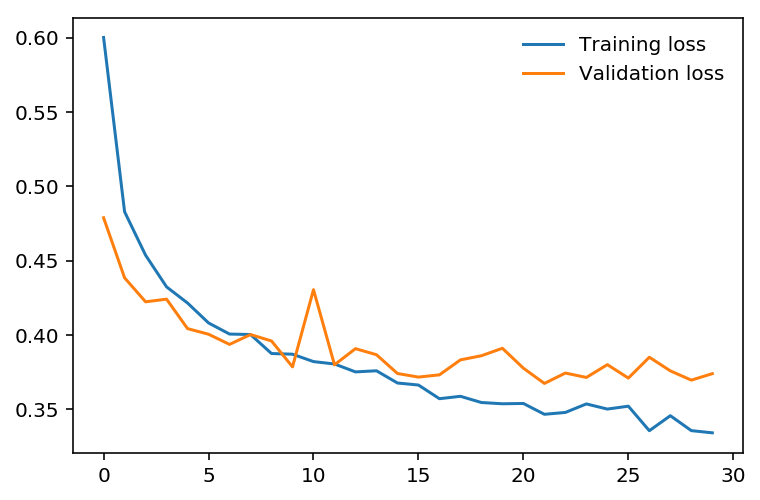

In [37]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

## Inference

Now that the model is trained, we can use it for inference. We've done this before, but now we need to remember to set the model in inference mode with `model.eval()`. You'll also want to turn off autograd with the `torch.no_grad()` context.

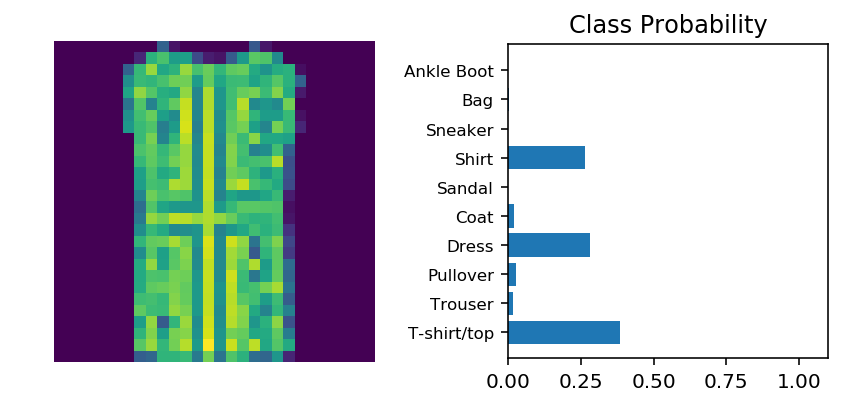

In [39]:
# Import helper module (should be in the repo)
import helper

# Test out your network!

model.eval()

dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[0]
# Convert 2D image to 1D vector
img = img.view(1, 784)

# Calculate the class probabilities (softmax) for img
with torch.no_grad():
    output = model.forward(img)

ps = torch.exp(output)

# Plot the image and probabilities
helper.view_classify(img.view(1, 28, 28), ps, version='Fashion')

## Next Up!

In the next part, I'll show you how to save your trained models. In general, you won't want to train a model everytime you need it. Instead, you'll train once, save it, then load the model when you want to train more or use if for inference.